# imports, data

In [ ]:
from datetime import timedelta
import os, sys
import random
import time

cwd = os.getcwd()

parentdir = os.path.dirname(cwd)
golemdir = parentdir + '/GOLEM'
bamtdir = parentdir + '/BAMT'
sys.path.insert(0, golemdir)
sys.path.insert(0, bamtdir)


import pandas as pd

from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from golem.core.adapter import DirectAdapter
from golem.core.dag.convert import graph_structure_as_nx_graph
from golem.core.dag.graph_utils import ordered_subnodes_hierarchy
from golem.core.dag.verification_rules import has_no_cycle, has_no_self_cycled_nodes
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.crossover import CrossoverTypesEnum
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.optimisers.graph import OptGraph, OptNode
from golem.core.optimisers.objective import Objective, ObjectiveEvaluate
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.optimizer import GraphGenerationParams


from divided_bn import DividedBN
import bamt.preprocessors as pp
from sklearn import preprocessing

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import multiprocessing as mp
mp.set_start_method('fork')

In [ ]:
pigs = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs.csv')
win95pts = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts.csv')
hailfinder = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder.csv')
hepar2 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2.csv')
arth150 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150.csv')
ecoli70 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70.csv', index_col=0)
magic_irri = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri.csv', index_col=0)
magic_niab = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab.csv', index_col=0)
diabetes = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/diabetes.csv')
andes = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/andes.csv')

pigs_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_true.csv')
win95pts_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_true.csv')
hailfinder_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_true.csv')
hepar2_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_true.csv')
arth150_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_true.csv')
ecoli70_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_true.csv')
magic_irri_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_true.csv')
magic_niab_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_true.csv')
andes_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/andes_true.csv')
diabetes_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/diabetes_true.csv')

# extras, algorithm

In [ ]:
import math

import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OrdinalEncoder


class BigBraveBN:
    def __init__(self):
        self.possible_edges = []

    def set_possible_edges_by_brave(
        self,
        df: pd.DataFrame,
        n_nearest: int = 5,
        threshold: float = 0.3,
        proximity_metric: str = "MI",
    ) -> list:
        """Returns list of possible edges for structure learning and sets it into attribute

        Args:
            df (pd.DataFrame): Data.
            n_nearest (int): Number of nearest neighbors to consider. Default is 5.
            threshold (float): Threshold for selecting edges. Default is 0.3.
            proximity_metric (str): Metric used to calculate proximity. Default is "MI".

        Returns:
            None: Modifies the object's possible_edges attribute.
        """
        df_copy = df.copy(deep=True)
        proximity_matrix = self._get_proximity_matrix(df_copy, proximity_metric)
        brave_matrix = self._get_brave_matrix(df_copy.columns, proximity_matrix, n_nearest)

        threshold_value = brave_matrix.max(numeric_only=True).max() * threshold
        filtered_brave_matrix = brave_matrix[brave_matrix > threshold_value].stack()
        self.possible_edges = filtered_brave_matrix.index.tolist()
        return self.possible_edges

    @staticmethod
    def _get_n_nearest(
        data: pd.DataFrame, columns: list, corr: bool = False, number_close: int = 5
    ) -> list:
        """Returns N nearest neighbors for every column of dataframe."""
        groups = []
        for c in columns:
            close_ind = data[c].sort_values(ascending=not corr).index.tolist()
            groups.append(close_ind[: number_close + 1])
        return groups

    @staticmethod
    def _get_proximity_matrix(df: pd.DataFrame, proximity_metric: str) -> pd.DataFrame:
        """Returns matrix of proximity for the dataframe."""
        encoder = OrdinalEncoder()
        df_coded = df.copy()
        columns_to_encode = list(df_coded.select_dtypes(include=["category", "object"]))
        df_coded[columns_to_encode] = encoder.fit_transform(df_coded[columns_to_encode])

        if proximity_metric == "MI":
            df_distance = pd.DataFrame(
                np.zeros((len(df.columns), len(df.columns))),
                columns=df.columns,
                index=df.columns,
            )
            for c1 in df.columns:
                for c2 in df.columns:
                    dist = mutual_info_score(df_coded[c1].values, df_coded[c2].values)
                    df_distance.loc[c1, c2] = dist
            return df_distance

        elif proximity_metric == "pearson":
            return df_coded.corr(method="pearson")

    def _get_brave_matrix(
        self, df_columns: pd.Index, proximity_matrix: pd.DataFrame, n_nearest: int = 5
    ) -> pd.DataFrame:
        """Returns matrix of Brave coefficients for the DataFrame."""
        brave_matrix = pd.DataFrame(
            np.zeros((len(df_columns), len(df_columns))),
            columns=df_columns,
            index=df_columns,
        )
        groups = self._get_n_nearest(
            proximity_matrix, df_columns.tolist(), corr=True, number_close=n_nearest
        )

        for c1 in df_columns:
            for c2 in df_columns:
                a = b = c = d = 0.0
                if c1 != c2:
                    for g in groups:
                        a += (c1 in g) & (c2 in g)
                        b += (c1 in g) & (c2 not in g)
                        c += (c1 not in g) & (c2 in g)
                        d += (c1 not in g) & (c2 not in g)

                    divisor = (math.sqrt((a + c) * (b + d))) * (
                        math.sqrt((a + b) * (c + d))
                    )
                    br = (a * len(groups) + (a + c) * (a + b)) / (
                        divisor if divisor != 0 else 0.0000000001
                    )
                    brave_matrix.loc[c1, c2] = br

        return brave_matrix

In [ ]:
def f1_score(custom_dag_edges, reference_dag_edges):
    # Calculate True Positives (tp), False Positives (fp), and False Negatives (fn)
    tp = fp = fn = 0
    for edge in custom_dag_edges:
        if edge in reference_dag_edges:
            tp += 1
        else:
            fp += 1

    for edge in reference_dag_edges:
        if edge not in custom_dag_edges:
            fn += 1

    # Calculate Precision and Recall
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return f1

def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal = 4):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'SHD': shd}

def f1_score_undirected(custom_dag_edges, reference_dag_edges):
    # Convert edges to sets (ignoring direction) and convert objects inside edges to strings
    custom_dag_edges_set = {frozenset((str(a), str(b))) for a, b in custom_dag_edges}
    reference_dag_edges_set = {frozenset((str(a), str(b))) for a, b in reference_dag_edges}

    # Calculate True Positives (tp), False Positives (fp), and False Negatives (fn)
    tp = fp = fn = 0
    for edge in custom_dag_edges_set:
        if edge in reference_dag_edges_set:
            tp += 1
        else:
            fp += 1

    for edge in reference_dag_edges_set:
        if edge not in custom_dag_edges_set:
            fn += 1

    # Calculate Precision and Recall
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return f1



In [ ]:
class CustomGraphModel(OptGraph):
    def evaluate(self, data: pd.DataFrame):
        nodes = data.columns.to_list()
        _, labels = graph_structure_as_nx_graph(self)
        return len(nodes)


class CustomGraphNode(OptNode):
    def __str__(self):
        return f'{self.content["name"]}'


def custom_metric(graph: CustomGraphModel, data: pd.DataFrame):
    graph_nx, labels = graph_structure_as_nx_graph(graph)
    struct = []
    for meta_edge in graph_nx.edges():
        l1 = str(labels[meta_edge[0]])
        l2 = str(labels[meta_edge[1]])
        struct.append([l1, l2])

    bn_model = BayesianNetwork(struct)
    bn_model.add_nodes_from(data.columns)

    score = K2Score(data).score(bn_model)
    return -score


def custom_mutation_add(graph: CustomGraphModel, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            nodes_not_cycling = (random_node.descriptive_id not in
                                 [n.descriptive_id for n in ordered_subnodes_hierarchy(other_random_node)] and
                                 other_random_node.descriptive_id not in
                                 [n.descriptive_id for n in ordered_subnodes_hierarchy(random_node)])
            if nodes_not_cycling:
                random_node.nodes_from.append(other_random_node)
                break

    except Exception as ex:
        print(f'Incorrect connection: {ex}')
    return graph


def custom_mutation_delete(graph: OptGraph, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                random_node.nodes_from.remove(other_random_node)
                break
    except Exception as ex:
        print(ex)
    return graph


def custom_mutation_reverse(graph: OptGraph, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                random_node.nodes_from.remove(other_random_node)
                other_random_node.nodes_from.append(random_node)
                break
    except Exception as ex:
        print(ex)
    return graph


def _has_no_duplicates(graph):
    _, labels = graph_structure_as_nx_graph(graph)
    if len(labels.values()) != len(set(labels.values())):
        raise ValueError('Custom graph has duplicates')
    return True


In [ ]:
def get_edges_by_localstructures(data,
                                 datatype="discrete",
                                 max_local_structures=8,
                                 hidden_nodes_clusters=None,
                                 time_m=5,
                                 history_dir=golemdir):

    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)

    initial_df = data.copy()

    # initialize divided_bn

    start_time = time.time()

    divided_bn = DividedBN(data=data,
                           data_type=datatype,
                           max_local_structures=max_local_structures,
                           hidden_nodes_clusters=hidden_nodes_clusters)

    divided_bn.set_local_structures()

    local_edges = divided_bn.local_structures_edges

    divided_bn.set_hidden_nodes(data=data)

    hidden_df = pd.DataFrame.from_dict(divided_bn.hidden_nodes)

    hidden_df.columns = hidden_df.columns.astype(str)

    root_nodes = divided_bn.root_nodes
    child_nodes = divided_bn.child_nodes

    vertices = list(hidden_df.columns)

    encoder = preprocessing.LabelEncoder()
    discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
    discretized_data, _ = p.apply(hidden_df)

    objective = Objective({'custom': custom_metric})
    objective_eval = ObjectiveEvaluate(objective, data=discretized_data)

    initial = [CustomGraphModel(nodes=[CustomGraphNode(nodes_from=None,
                                                    content={'name': vertex,
                                                            'type': p.nodes_types[vertex],
                                                            'parent_model': None}) 
                                                    for vertex in vertices])]
    init = initial[0]

    requirements = GraphRequirements(
        max_arity=20,
        max_depth=20,
        num_of_generations=75,
        timeout=timedelta(minutes=time_m),
        n_jobs=-1)

    optimizer_parameters = GPAlgorithmParameters(
        pop_size=20,
        crossover_prob=0.8,
        mutation_prob=0.9,
        genetic_scheme_type=GeneticSchemeTypesEnum.steady_state,
        mutation_types=[custom_mutation_add, custom_mutation_delete, custom_mutation_reverse],
        crossover_types=[CrossoverTypesEnum.exchange_edges,
        CrossoverTypesEnum.exchange_parents_one,
        CrossoverTypesEnum.exchange_parents_both],
        selection_types=[SelectionTypesEnum.tournament])

    adapter = DirectAdapter(base_graph_class=CustomGraphModel, base_node_class=CustomGraphNode)
    constraints = [has_no_self_cycled_nodes, has_no_cycle, _has_no_duplicates]
    graph_generation_params = GraphGenerationParams(
        adapter=adapter,
        rules_for_constraint=constraints)

    optimiser = EvoGraphOptimizer(
            objective=objective,
            requirements=requirements,
            initial_graphs=[init],
            graph_generation_params=graph_generation_params,
            graph_optimizer_params=optimizer_parameters
            )


    optimized_graph = optimiser.optimise(objective_eval)[0]

    print("--- %s seconds ---" % (time.time() - start_time))

    evolutionary_edges = optimized_graph.operator.get_edges()

    print(evolutionary_edges)

    local_edges_merged = []

    for key in local_edges:
         local_edges_merged += local_edges[key]

    # external_edges = divided_bn.connect_structures_simple(evolutionary_edges)

    # external_edges = divided_bn.connect_structures_hc(evolutionary_edges)

    external_edges = divided_bn.connect_structures_spearman(evolutionary_edges, percentile_threshold=95)

    external_edges_merged = []

    for key in external_edges:
            external_edges_merged += external_edges[key]

    all_edges = local_edges_merged + external_edges_merged

    def remove_duplicates(input_list):
        unique_list = []
        for item in input_list:
            if item not in unique_list:
                unique_list.append(item)
        return unique_list


    def convert_to_strings(nested_list):
        return [[str(item) for item in inner_list] for inner_list in nested_list]

    return remove_duplicates(convert_to_strings(all_edges))


In [ ]:
evo, evo_edges, loc_edges = get_edges_by_localstructures(data=diabetes, datatype="discrete", hidden_nodes_clusters=8, max_local_structures=10)


In [ ]:
local_structures = {
    2: [
        ["ins_sens", "activ_ins_4"],
        ["ins_sens", "ins_abs_5"],
        ["ins_sens", "ins_indep_3"],
        ["ins_sens", "ins_abs_1"],
        ["ins_sens", "ins_indep_util_2"],
        ["bg_1", "renal_cl_1"],
        ["renal_cl_1", "meal_0"],
        ["renal_cl_1", "cho_init"],
        ["renal_cl_1", "ins_abs_1"],
        ["renal_cl_2", "endo_bal_2"],
        ["renal_cl_2", "glu_prod_2"],
        ["renal_cl_2", "renal_cl_1"],
        ["renal_cl_2", "bg_1"],
        ["renal_cl_2", "ins_abs_1"],
        ["renal_cl_2", "meal_0"],
        ["renal_cl_2", "ins_dep_util_2"],
        ["renal_cl_2", "cho_init"],
        ["ins_indep_util_2", "glu_prod_2"],
        ["ins_indep_util_2", "renal_cl_2"],
        ["ins_indep_util_2", "ins_abs_1"],
        ["ins_indep_util_2", "endo_bal_2"],
        ["ins_indep_util_2", "bg_1"],
        ["ins_indep_util_2", "ins_dep_util_2"],
        ["ins_dep_util_2", "endo_bal_2"],
        ["ins_dep_util_2", "glu_prod_2"],
        ["endo_bal_2", "glu_prod_2"],
        ["ins_indep_3", "ins_dep_3"],
        ["ins_indep_3", "bg_4"],
        ["ins_indep_3", "ins_indep_util_2"],
        ["ins_indep_3", "ins_dep_util_2"],
        ["ins_indep_3", "renal_cl_2"],
        ["endo_bal_3", "ins_dep_3"],
        ["endo_bal_3", "ins_indep_3"],
        ["cho_bal_3", "cho_4"],
        ["cho_bal_3", "endo_bal_3"],
        ["cho_bal_3", "meal_1"],
        ["cho_bal_3", "basal_bal_3"],
        ["basal_bal_3", "tot_bal_3"],
        ["basal_bal_3", "endo_bal_3"],
        ["met_irr_3", "tot_bal_3"],
        ["tot_bal_3", "bg_4"],
        ["meal_4", "cho_4"],
        ["meal_4", "cho_bal_3"],
        ["bg_4", "ins_indep_util_5"],
        ["bg_4", "ins_indep_5"],
        ["bg_4", "basal_bal_4"],
        ["activ_ins_4", "basal_bal_4"],
        ["activ_ins_4", "ins_indep_util_5"],
        ["ins_abs_4", "activ_ins_4"],
        ["basal_bal_4", "tot_bal_4"],
        ["met_irr_4", "tot_bal_4"],
        ["tot_bal_4", "ins_indep_5"],
        ["cho_5", "cho_bal_3"],
        ["cho_5", "basal_bal_5"],
        ["cho_5", "meal_4"],
        ["ins_abs_5", "endo_bal_6"],
        ["renal_cl_5", "basal_bal_5"],
        ["renal_cl_5", "endo_bal_6"],
        ["renal_cl_5", "bg_7"],
        ["ins_indep_util_5", "basal_bal_5"],
        ["ins_indep_util_5", "bg_7"],
        ["ins_dep_util_5", "glu_prod_5"],
        ["ins_dep_util_5", "basal_bal_5"],
        ["ins_dep_util_5", "ins_abs_5"],
        ["ins_dep_util_5", "ins_abs_4"],
        ["ins_dep_util_5", "ins_sens"],
        ["glu_prod_5", "ins_abs_5"],
        ["glu_prod_5", "ins_sens"],
        ["glu_prod_5", "basal_bal_5"],
        ["ins_indep_5", "renal_cl_5"],
        ["ins_indep_5", "bg_7"],
        ["ins_indep_5", "ins_abs_5"],
        ["ins_indep_5", "ins_indep_util_5"],
        ["basal_bal_5", "tot_bal_5"],
        ["met_irr_5", "tot_bal_5"],
        ["tot_bal_5", "bg_7"],
        ["meal_6", "cho_5"],
        ["cho_6", "cho_5"],
        ["cho_6", "meal_6"],
        ["cho_6", "tot_bal_6"],
        ["endo_bal_6", "tot_bal_6"],
        ["tot_bal_6", "bg_7"],
        ["meal_7", "cho_7"],
        ["meal_7", "cho_6"],
        ["cho_7", "cho_6"],
        ["cho_7", "cho_9"],
        ["cho_7", "tot_bal_7"],
        ["met_irr_8", "tot_bal_8"],
        ["cho_9", "basal_bal_9"],
        ["cho_9", "meal_9"],
    ],
    1: [
        ["cho_0", "gut_abs_1"],
        ["gut_abs_1", "basal_bal_1"],
        ["gut_abs_1", "ins_indep_2"],
        ["gut_abs_1", "gut_abs_5"],
        ["basal_bal_1", "ins_indep_2"],
        ["ins_indep_2", "ins_dep_2"],
        ["ins_indep_2", "bg_5"],
        ["ins_indep_2", "renal_cl_18"],
        ["gut_abs_5", "bg_5"],
        ["gut_abs_7", "gut_abs_5"],
        ["tot_bal_9", "met_irr_9"],
        ["renal_cl_11", "bg_11"],
        ["renal_cl_11", "tot_bal_9"],
        ["renal_cl_11", "gut_abs_7"],
        ["ins_indep_util_12", "renal_cl_11"],
        ["ins_indep_util_12", "ins_indep_13"],
        ["ins_indep_util_12", "bg_11"],
        ["ins_indep_util_12", "renal_cl_12"],
        ["endo_bal_14", "ins_dep_14"],
        ["cho_bal_14", "gut_abs_15"],
        ["cho_bal_14", "gut_abs_12"],
        ["tot_bal_17", "bg_17"],
        ["tot_bal_17", "activ_ins_17"],
        ["bg_18", "tot_bal_17"],
        ["bg_18", "activ_ins_17"],
        ["bg_18", "bg_17"],
        ["bg_18", "bg_19"],
        ["bg_18", "glu_prod_18"],
        ["renal_cl_18", "bg_18"],
        ["renal_cl_18", "activ_ins_11"],
        ["renal_cl_18", "ins_dep_2"],
        ["bg_19", "glu_prod_18"],
        ["activ_ins_19", "tot_bal_20"],
        ["meal_21", "cho_21"],
        ["meal_21", "cho_19"],
        ["cho_21", "cho_19"],
        ["cho_21", "ins_indep_util_22"],
        ["ins_indep_util_22", "renal_cl_18"],
        ["ins_indep_util_22", "tot_bal_20"],
        ["ins_indep_util_22", "ins_dep_util_22"],
        ["ins_indep_util_22", "glu_prod_22"],
        ["ins_indep_util_22", "activ_ins_19"],
        ["ins_dep_util_22", "glu_prod_22"],
        ["glu_prod_22", "tot_bal_23"],
        ["tot_bal_10", "met_irr_10"],
        ["tot_bal_10", "tot_bal_9"],
        ["bg_11", "ins_indep_util_11"],
        ["bg_11", "tot_bal_10"],
        ["bg_11", "tot_bal_9"],
        ["activ_ins_11", "renal_cl_12"],
        ["activ_ins_11", "ins_indep_util_12"],
        ["activ_ins_11", "activ_ins_5"],
        ["ins_abs_11", "activ_ins_11"],
        ["ins_abs_11", "activ_ins_5"],
        ["ins_abs_11", "renal_cl_11"],
        ["gut_abs_11", "meal_11"],
        ["gut_abs_11", "renal_cl_12"],
        ["gut_abs_11", "ins_indep_util_12"],
        ["gut_abs_11", "gut_abs_7"],
        ["activ_ins_12", "activ_ins_19"],
        ["gut_abs_12", "gut_abs_11"],
        ["gut_abs_12", "activ_ins_12"],
        ["gut_abs_12", "endo_bal_13"],
        ["gut_abs_12", "endo_bal_14"],
        ["renal_cl_12", "renal_cl_11"],
        ["renal_cl_12", "ins_indep_13"],
        ["renal_cl_12", "bg_11"],
        ["renal_cl_12", "activ_ins_12"],
        ["renal_cl_12", "met_irr_12"],
        ["renal_cl_12", "ins_dep_util_22"],
        ["renal_cl_12", "bg_18"],
        ["ins_indep_13", "ins_dep_13"],
        ["ins_indep_13", "activ_ins_12"],
        ["ins_indep_13", "ins_dep_14"],
        ["ins_indep_13", "met_irr_12"],
        ["ins_dep_13", "glu_prod_13"],
        ["endo_bal_13", "ins_dep_13"],
        ["endo_bal_13", "ins_indep_13"],
        ["gut_abs_15", "renal_cl_18"],
    ],
    0: [
        ["activ_ins_0", "ins_abs_0"],
        ["gut_abs_0", "ins_dep_0"],
        ["gut_abs_0", "ins_indep_1"],
        ["renal_cl_0", "ins_dep_0"],
        ["renal_cl_0", "ins_indep_util_0"],
        ["renal_cl_0", "activ_ins_0"],
        ["ins_indep_util_0", "activ_ins_0"],
        ["ins_dep_0", "activ_ins_0"],
        ["ins_dep_0", "ins_indep_util_0"],
        ["ins_indep_util_1", "ins_dep_0"],
        ["ins_dep_util_1", "glu_prod_1"],
        ["ins_indep_1", "ins_dep_1"],
        ["ins_indep_1", "ins_dep_0"],
        ["ins_indep_1", "endo_bal_1"],
        ["ins_indep_1", "ins_indep_util_1"],
        ["ins_indep_1", "renal_cl_0"],
        ["ins_indep_1", "ins_indep_util_0"],
        ["ins_dep_1", "glu_prod_1"],
        ["ins_dep_1", "ins_dep_util_1"],
        ["endo_bal_1", "ins_dep_1"],
        ["cho_bal_1", "cho_bal_2"],
        ["cho_bal_1", "gut_abs_0"],
        ["cho_bal_2", "cho_3"],
        ["cho_bal_2", "basal_bal_2"],
        ["basal_bal_2", "tot_bal_2"],
        ["met_irr_2", "tot_bal_2"],
        ["ins_abs_9", "activ_ins_9"],
        ["gut_abs_9", "bg_9"],
        ["gut_abs_9", "meal_5"],
        ["cho_11", "gut_abs_9"],
        ["cho_11", "ins_indep_12"],
        ["ins_dep_util_12", "ins_dep_12"],
        ["ins_dep_util_12", "glu_prod_12"],
        ["ins_indep_12", "basal_bal_12"],
        ["ins_indep_12", "bg_9"],
        ["ins_indep_12", "ins_dep_util_12"],
        ["ins_dep_12", "glu_prod_12"],
        ["ins_dep_12", "basal_bal_12"],
        ["cho_bal_13", "cho_11"],
        ["cho_bal_13", "basal_bal_13"],
        ["basal_bal_13", "tot_bal_13"],
        ["met_irr_13", "tot_bal_13"],
        ["ins_abs_16", "renal_cl_16"],
        ["renal_cl_16", "activ_ins_20"],
        ["renal_cl_16", "cho_bal_13"],
        ["renal_cl_16", "ins_abs_0"],
        ["renal_cl_16", "meal_14"],
        ["renal_cl_16", "activ_ins_9"],
        ["renal_cl_16", "ins_indep_1"],
        ["renal_cl_16", "ins_indep_12"],
        ["renal_cl_16", "met_irr_14"],
        ["renal_cl_16", "endo_bal_1"],
        ["renal_cl_16", "endo_bal_22"],
        ["renal_cl_16", "ins_dep_5"],
        ["endo_bal_16", "ins_abs_16"],
        ["endo_bal_16", "renal_cl_16"],
        ["activ_ins_20", "bg_21"],
        ["ins_abs_20", "activ_ins_20"],
        ["ins_abs_20", "renal_cl_20"],
        ["gut_abs_20", "bg_21"],
        ["gut_abs_20", "activ_ins_21"],
        ["renal_cl_20", "activ_ins_9"],
        ["renal_cl_20", "ins_dep_5"],
        ["renal_cl_20", "ins_dep_util_12"],
        ["bg_21", "ins_indep_22"],
        ["bg_21", "renal_cl_20"],
        ["cho_22", "gut_abs_20"],
        ["bg_22", "activ_ins_21"],
        ["ins_indep_22", "bg_22"],
        ["ins_indep_22", "ins_dep_22"],
        ["ins_indep_22", "endo_bal_22"],
        ["endo_bal_22", "ins_dep_22"],
    ],
    7: [
        ["ins_dep_util_0", "endo_bal_0"],
        ["ins_dep_util_0", "glu_prod_0"],
        ["ins_dep_util_0", "ins_indep_0"],
        ["glu_prod_0", "tot_bal_1"],
        ["glu_prod_0", "ins_indep_0"],
        ["endo_bal_0", "glu_prod_0"],
        ["endo_bal_0", "ins_indep_0"],
        ["cho_bal_0", "cho_2"],
        ["activ_ins_1", "bg_2"],
        ["tot_bal_1", "met_irr_1"],
        ["meal_2", "cho_2"],
        ["cho_2", "gut_abs_2"],
        ["cho_2", "gut_abs_3"],
        ["bg_2", "tot_bal_1"],
        ["bg_2", "renal_cl_3"],
        ["bg_2", "ins_dep_util_0"],
        ["bg_2", "ins_abs_2"],
        ["bg_2", "bg_3"],
        ["ins_abs_2", "activ_ins_2"],
        ["gut_abs_2", "bg_2"],
        ["gut_abs_2", "renal_cl_3"],
        ["meal_3", "gut_abs_3"],
        ["bg_3", "ins_indep_util_3"],
        ["bg_3", "glu_prod_3"],
        ["bg_3", "ins_abs_2"],
        ["activ_ins_3", "glu_prod_3"],
        ["activ_ins_3", "ins_dep_util_3"],
        ["ins_abs_3", "activ_ins_3"],
        ["gut_abs_3", "cho_bal_5"],
        ["gut_abs_3", "endo_bal_5"],
        ["renal_cl_3", "bg_3"],
        ["renal_cl_3", "ins_dep_util_3"],
        ["renal_cl_3", "activ_ins_2"],
        ["renal_cl_3", "activ_ins_13"],
        ["renal_cl_3", "activ_ins_3"],
        ["ins_indep_util_3", "ins_dep_util_3"],
        ["cho_bal_5", "ins_indep_9"],
        ["renal_cl_9", "activ_ins_10"],
        ["renal_cl_9", "bg_13"],
        ["renal_cl_9", "renal_cl_13"],
        ["renal_cl_9", "endo_bal_11"],
        ["renal_cl_9", "bg_10"],
        ["renal_cl_9", "endo_bal_9"],
        ["ins_indep_util_9", "bg_10"],
        ["ins_dep_util_9", "glu_prod_9"],
        ["ins_dep_util_9", "cho_bal_9"],
        ["ins_indep_9", "ins_dep_9"],
        ["ins_indep_9", "renal_cl_9"],
        ["ins_indep_9", "ins_indep_util_9"],
        ["ins_indep_9", "bg_10"],
        ["ins_indep_9", "endo_bal_9"],
        ["ins_dep_9", "glu_prod_9"],
        ["ins_dep_9", "ins_dep_util_9"],
        ["endo_bal_9", "ins_dep_9"],
        ["endo_bal_9", "bg_10"],
        ["bg_10", "cho_bal_9"],
        ["bg_10", "renal_cl_13"],
        ["activ_ins_10", "activ_ins_1"],
        ["ins_abs_10", "activ_ins_10"],
        ["ins_abs_10", "activ_ins_1"],
        ["ins_dep_11", "ins_abs_10"],
        ["endo_bal_11", "ins_dep_11"],
        ["endo_bal_11", "ins_abs_10"],
        ["endo_bal_12", "ins_abs_12"],
        ["cho_bal_12", "cho_13"],
        ["cho_bal_12", "endo_bal_12"],
        ["tot_bal_12", "endo_bal_12"],
        ["meal_13", "cho_13"],
        ["cho_13", "gut_abs_13"],
        ["cho_13", "cho_14"],
        ["bg_13", "tot_bal_12"],
        ["bg_13", "cho_bal_12"],
        ["ins_abs_13", "activ_ins_13"],
        ["renal_cl_13", "bg_13"],
        ["renal_cl_13", "ins_abs_12"],
        ["renal_cl_13", "activ_ins_10"],
        ["renal_cl_13", "activ_ins_3"],
        ["renal_cl_13", "ins_dep_11"],
        ["renal_cl_13", "activ_ins_13"],
        ["renal_cl_13", "activ_ins_2"],
        ["renal_cl_13", "endo_bal_11"],
    ],
    8: [
        ["glu_prod_6", "glu_prod_17"],
        ["cho_bal_8", "cho_bal_10"],
        ["basal_bal_8", "cho_bal_8"],
        ["cho_bal_10", "basal_bal_10"],
    ],
    4: [
        ["gut_abs_4", "gut_abs_6"],
        ["renal_cl_4", "gut_abs_4"],
        ["renal_cl_4", "ins_dep_util_8"],
        ["renal_cl_4", "ins_abs_6"],
        ["renal_cl_4", "ins_dep_util_10"],
        ["ins_indep_4", "renal_cl_4"],
        ["ins_indep_4", "ins_indep_util_4"],
        ["ins_indep_4", "glu_prod_4"],
        ["activ_ins_6", "ins_abs_6"],
        ["activ_ins_6", "ins_indep_7"],
        ["gut_abs_6", "ins_indep_7"],
        ["gut_abs_6", "gut_abs_8"],
        ["gut_abs_6", "renal_cl_8"],
        ["ins_indep_6", "activ_ins_6"],
        ["ins_indep_6", "gut_abs_4"],
        ["ins_indep_6", "ins_indep_4"],
        ["ins_indep_6", "ins_dep_6"],
        ["ins_indep_6", "glu_prod_4"],
        ["ins_indep_6", "ins_indep_7"],
        ["ins_dep_6", "activ_ins_6"],
        ["activ_ins_7", "ins_abs_7"],
        ["activ_ins_7", "renal_cl_8"],
        ["activ_ins_7", "ins_indep_util_8"],
        ["glu_prod_7", "activ_ins_7"],
        ["ins_indep_7", "activ_ins_7"],
        ["ins_indep_7", "renal_cl_8"],
        ["ins_indep_7", "ins_indep_util_8"],
        ["ins_indep_7", "ins_dep_7"],
        ["ins_dep_7", "glu_prod_7"],
        ["ins_dep_7", "activ_ins_7"],
        ["gut_abs_8", "renal_cl_10"],
        ["renal_cl_8", "renal_cl_10"],
        ["renal_cl_8", "glu_prod_8"],
        ["renal_cl_8", "ins_indep_util_8"],
        ["ins_indep_util_8", "ins_dep_util_8"],
        ["ins_indep_util_8", "glu_prod_8"],
        ["ins_indep_util_8", "renal_cl_10"],
        ["ins_dep_util_8", "glu_prod_8"],
        ["glu_prod_8", "renal_cl_10"],
        ["gut_abs_10", "gut_abs_8"],
        ["gut_abs_10", "gut_abs_6"],
        ["renal_cl_10", "ins_dep_util_10"],
        ["cho_bal_11", "gut_abs_10"],
        ["basal_bal_11", "tot_bal_11"],
        ["basal_bal_11", "cho_bal_11"],
        ["met_irr_11", "tot_bal_11"],
        ["bg_15", "activ_ins_15"],
        ["activ_ins_15", "ins_abs_15"],
        ["renal_cl_15", "ins_abs_15"],
        ["renal_cl_15", "basal_bal_11"],
        ["renal_cl_15", "ins_dep_util_10"],
        ["renal_cl_15", "ins_dep_6"],
        ["renal_cl_15", "ins_indep_4"],
        ["renal_cl_15", "bg_15"],
        ["ins_indep_util_15", "bg_15"],
        ["ins_dep_util_15", "ins_dep_15"],
        ["ins_dep_util_15", "activ_ins_15"],
        ["ins_dep_util_15", "ins_indep_15"],
        ["ins_indep_15", "bg_15"],
        ["ins_indep_15", "renal_cl_15"],
        ["ins_indep_15", "ins_indep_util_15"],
        ["ins_indep_15", "ins_indep_6"],
        ["ins_dep_15", "activ_ins_15"],
        ["ins_dep_15", "ins_indep_15"],
        ["cho_17", "gut_abs_17"],
        ["gut_abs_17", "renal_cl_17"],
        ["gut_abs_17", "ins_dep_util_17"],
        ["renal_cl_17", "ins_indep_15"],
        ["renal_cl_17", "ins_abs_6"],
        ["renal_cl_17", "ins_abs_7"],
        ["renal_cl_17", "ins_dep_util_15"],
        ["renal_cl_17", "basal_bal_18"],
        ["renal_cl_17", "ins_dep_7"],
        ["renal_cl_17", "ins_indep_6"],
        ["renal_cl_17", "bg_15"],
        ["renal_cl_17", "ins_dep_18"],
        ["renal_cl_17", "glu_prod_4"],
        ["renal_cl_17", "met_irr_15"],
        ["ins_indep_util_17", "renal_cl_17"],
        ["ins_dep_util_17", "ins_dep_17"],
        ["ins_dep_util_17", "ins_indep_util_17"],
        ["ins_dep_util_17", "basal_bal_18"],
        ["ins_dep_17", "ins_indep_util_17"],
        ["cho_18", "cho_17"],
        ["cho_18", "endo_bal_18"],
        ["cho_18", "ins_indep_util_19"],
        ["endo_bal_18", "ins_dep_18"],
        ["cho_bal_18", "cho_18"],
        ["cho_bal_18", "gut_abs_19"],
        ["cho_bal_18", "endo_bal_18"],
        ["basal_bal_18", "endo_bal_18"],
        ["ins_indep_util_19", "ins_dep_18"],
        ["ins_indep_util_19", "basal_bal_18"],
        ["ins_indep_util_19", "ins_indep_util_17"],
        ["ins_indep_util_19", "ins_dep_util_17"],
        ["ins_indep_util_19", "renal_cl_17"],
    ],
    3: [
        ["cho_1", "tot_bal_0"],
        ["ins_dep_4", "ins_dep_util_4"],
        ["endo_bal_4", "ins_dep_4"],
        ["cho_bal_6", "cho_8"],
        ["basal_bal_6", "bg_6"],
        ["met_irr_6", "bg_6"],
        ["renal_cl_7", "bg_6"],
        ["renal_cl_7", "bg_8"],
        ["renal_cl_7", "basal_bal_6"],
        ["renal_cl_7", "cho_bal_6"],
        ["renal_cl_7", "activ_ins_8"],
        ["renal_cl_7", "met_irr_6"],
        ["renal_cl_7", "ins_dep_4"],
        ["renal_cl_7", "ins_indep_11"],
        ["renal_cl_7", "ins_dep_util_18"],
        ["renal_cl_7", "ins_dep_util_11"],
        ["renal_cl_7", "endo_bal_4"],
        ["renal_cl_7", "endo_bal_15"],
        ["ins_indep_util_7", "bg_6"],
        ["ins_indep_util_7", "renal_cl_7"],
        ["ins_indep_util_7", "bg_8"],
        ["ins_indep_util_7", "basal_bal_6"],
        ["ins_indep_util_7", "cho_bal_6"],
        ["ins_indep_util_7", "met_irr_6"],
        ["ins_dep_util_7", "bg_8"],
        ["ins_dep_util_7", "ins_indep_util_7"],
        ["meal_8", "cho_8"],
        ["cho_8", "cho_10"],
        ["ins_abs_8", "activ_ins_8"],
        ["cho_10", "ins_indep_11"],
        ["cho_10", "meal_10"],
        ["ins_dep_util_11", "glu_prod_11"],
        ["ins_indep_11", "glu_prod_11"],
        ["ins_indep_11", "ins_dep_util_11"],
        ["basal_bal_14", "glu_prod_14"],
        ["glu_prod_15", "basal_bal_14"],
        ["endo_bal_15", "glu_prod_15"],
        ["endo_bal_15", "basal_bal_14"],
        ["cho_bal_15", "ins_indep_util_18"],
        ["basal_bal_17", "tot_bal_16"],
        ["ins_indep_util_18", "activ_ins_18"],
        ["ins_indep_util_18", "basal_bal_17"],
        ["ins_indep_util_18", "tot_bal_16"],
        ["ins_indep_util_18", "ins_dep_util_18"],
        ["ins_indep_util_18", "met_irr_17"],
        ["ins_indep_util_18", "ins_indep_util_7"],
        ["ins_indep_util_18", "glu_prod_15"],
        ["ins_indep_util_18", "ins_dep_util_7"],
        ["ins_indep_util_18", "renal_cl_7"],
        ["ins_dep_util_18", "activ_ins_18"],
        ["meal_19", "cho_bal_20"],
        ["meal_15", "cho_bal_15"],
        ["cho_bal_20", "gut_abs_21"],
        ["cho_bal_20", "basal_bal_20"],
        ["cho_bal_20", "cho_bal_22"],
        ["gut_abs_21", "cho_bal_22"],
        ["cho_bal_22", "gut_abs_23"],
        ["gut_abs_23", "cho_24"],
        ["gut_abs_23", "glu_prod_23"],
        ["gut_abs_23", "basal_bal_23"],
        ["basal_bal_23", "glu_prod_23"],
        ["basal_bal_23", "bg_24"],
        ["met_irr_23", "bg_24"],
        ["meal_24", "cho_24"],
        ["bg_24", "glu_prod_23"],
    ],
    9: [
        ["cho_bal_4", "cho_bal_7"],
        ["renal_cl_6", "cho_bal_4"],
        ["renal_cl_6", "ins_indep_8"],
        ["renal_cl_6", "basal_bal_7"],
        ["renal_cl_6", "ins_indep_18"],
        ["renal_cl_6", "ins_dep_util_6"],
        ["renal_cl_6", "ins_indep_util_10"],
        ["ins_indep_util_6", "renal_cl_6"],
        ["ins_indep_util_6", "ins_dep_util_6"],
        ["ins_indep_util_6", "cho_bal_4"],
        ["ins_dep_util_6", "basal_bal_7"],
        ["cho_bal_7", "endo_bal_7"],
        ["cho_bal_7", "ins_indep_8"],
        ["basal_bal_7", "endo_bal_7"],
        ["ins_indep_8", "ins_dep_8"],
        ["ins_indep_8", "endo_bal_8"],
        ["ins_indep_8", "basal_bal_7"],
        ["ins_indep_8", "ins_indep_util_10"],
        ["ins_indep_8", "ins_indep_10"],
        ["ins_indep_8", "ins_dep_util_6"],
        ["endo_bal_8", "ins_dep_8"],
        ["ins_indep_util_10", "ins_indep_10"],
        ["ins_indep_util_10", "endo_bal_10"],
        ["ins_indep_util_10", "bg_12"],
        ["glu_prod_10", "bg_12"],
        ["ins_indep_10", "ins_dep_10"],
        ["ins_indep_10", "endo_bal_10"],
        ["ins_indep_10", "bg_12"],
        ["ins_indep_10", "endo_bal_8"],
        ["ins_dep_10", "glu_prod_10"],
        ["endo_bal_10", "ins_dep_10"],
        ["meal_12", "cho_12"],
        ["cho_12", "cho_15"],
        ["cho_15", "basal_bal_15"],
        ["meal_17", "cho_bal_19"],
        ["meal_18", "cho_bal_19"],
        ["ins_indep_18", "tot_bal_14"],
        ["cho_bal_19", "cho_bal_21"],
        ["cho_bal_19", "ins_indep_util_21"],
        ["cho_bal_19", "ins_indep_21"],
        ["cho_bal_21", "cho_23"],
        ["ins_dep_19", "glu_prod_19"],
        ["ins_indep_util_21", "ins_indep_21"],
        ["ins_indep_util_21", "bg_23"],
        ["ins_indep_util_21", "activ_ins_23"],
        ["ins_indep_util_21", "ins_indep_18"],
        ["ins_dep_util_21", "bg_23"],
        ["ins_dep_util_21", "activ_ins_23"],
        ["ins_indep_21", "ins_dep_21"],
        ["ins_indep_21", "endo_bal_21"],
        ["ins_indep_21", "bg_23"],
        ["ins_indep_21", "ins_indep_18"],
        ["ins_indep_21", "activ_ins_23"],
        ["ins_indep_21", "ins_dep_19"],
        ["ins_indep_21", "renal_cl_6"],
        ["ins_dep_21", "ins_dep_util_21"],
        ["endo_bal_21", "ins_dep_21"],
        ["met_irr_22", "tot_bal_22"],
        ["tot_bal_22", "bg_23"],
        ["meal_23", "cho_23"],
        ["activ_ins_23", "ins_indep_util_6"],
    ],
    5: [
        ["glu_prod_16", "activ_ins_16"],
        ["tot_bal_19", "ins_abs_19"],
        ["ins_dep_util_13", "ins_indep_util_13"],
        ["activ_ins_16", "glu_prod_21"],
        ["ins_indep_util_16", "activ_ins_16"],
        ["ins_indep_util_16", "gut_abs_16"],
        ["ins_indep_16", "ins_indep_util_16"],
        ["ins_indep_16", "activ_ins_16"],
        ["ins_indep_16", "gut_abs_16"],
        ["ins_indep_16", "ins_indep_util_13"],
        ["ins_indep_16", "glu_prod_16"],
        ["ins_indep_16", "ins_dep_util_13"],
        ["meal_20", "cho_20"],
        ["cho_20", "renal_cl_21"],
        ["renal_cl_21", "ins_indep_16"],
        ["renal_cl_21", "met_irr_20"],
        ["renal_cl_21", "ins_abs_19"],
        ["renal_cl_21", "glu_prod_16"],
        ["renal_cl_21", "tot_bal_19"],
        ["renal_cl_21", "glu_prod_21"],
        ["renal_cl_21", "gut_abs_16"],
    ],
    6: [
        ["ins_indep_17", "endo_bal_17"],
        ["ins_indep_17", "ins_abs_17"],
        ["ins_indep_17", "ins_indep_19"],
        ["ins_indep_17", "met_irr_16"],
        ["tot_bal_18", "ins_indep_19"],
        ["tot_bal_18", "ins_abs_18"],
        ["ins_indep_19", "renal_cl_19"],
        ["ins_indep_19", "endo_bal_19"],
        ["ins_indep_19", "ins_indep_20"],
        ["ins_indep_19", "ins_dep_util_19"],
        ["endo_bal_19", "ins_indep_20"],
        ["tot_bal_15", "bg_16"],
        ["tot_bal_15", "ins_indep_14"],
        ["meal_16", "cho_bal_16"],
        ["meal_16", "gut_abs_14"],
        ["cho_16", "gut_abs_14"],
        ["cho_16", "basal_bal_16"],
        ["bg_16", "ins_indep_17"],
        ["bg_16", "ins_indep_14"],
        ["bg_16", "ins_dep_util_16"],
        ["ins_dep_util_16", "ins_dep_16"],
        ["ins_dep_16", "basal_bal_16"],
        ["endo_bal_17", "ins_abs_17"],
        ["cho_bal_17", "gut_abs_18"],
        ["gut_abs_18", "tot_bal_18"],
        ["renal_cl_19", "endo_bal_17"],
        ["renal_cl_19", "bg_20"],
        ["renal_cl_19", "met_irr_19"],
        ["renal_cl_19", "ins_indep_20"],
        ["ins_dep_util_19", "endo_bal_19"],
        ["bg_20", "endo_bal_20"],
        ["activ_ins_22", "ins_indep_23"],
        ["activ_ins_22", "renal_cl_22"],
        ["ins_abs_22", "activ_ins_22"],
        ["gut_abs_22", "ins_indep_23"],
        ["gut_abs_22", "meal_22"],
        ["gut_abs_22", "basal_bal_22"],
        ["gut_abs_22", "renal_cl_22"],
        ["gut_abs_22", "ins_abs_22"],
        ["renal_cl_22", "tot_bal_21"],
        ["renal_cl_22", "ins_indep_23"],
        ["renal_cl_22", "endo_bal_20"],
        ["renal_cl_22", "ins_dep_util_19"],
        ["basal_bal_22", "ins_abs_22"],
        ["basal_bal_22", "renal_cl_22"],
        ["renal_cl_23", "activ_ins_14"],
        ["ins_indep_23", "ins_dep_23"],
        ["ins_indep_23", "renal_cl_23"],
        ["ins_indep_23", "ins_indep_util_23"],
        ["ins_indep_23", "endo_bal_23"],
        ["ins_dep_23", "ins_dep_util_23"],
        ["endo_bal_23", "ins_dep_23"],
        ["cho_bal_23", "gut_abs_22"],
        ["activ_ins_14", "ins_dep_util_14"],
        ["activ_ins_14", "bg_16"],
        ["ins_abs_14", "activ_ins_14"],
        ["ins_abs_14", "tot_bal_15"],
        ["renal_cl_14", "gut_abs_14"],
        ["renal_cl_14", "bg_14"],
        ["renal_cl_14", "ins_dep_util_14"],
        ["ins_indep_14", "bg_14"],
        ["ins_indep_14", "renal_cl_14"],
        ["ins_indep_14", "ins_indep_util_14"],
        ["ins_indep_14", "ins_dep_util_14"],
        ["cho_bal_16", "cho_16"],
        ["cho_bal_16", "cho_bal_17"],
        ["basal_bal_16", "ins_indep_17"],
        ["ins_indep_util_20", "tot_bal_21"],
        ["ins_indep_util_20", "bg_20"],
        ["ins_dep_util_20", "glu_prod_20"],
        ["glu_prod_20", "tot_bal_21"],
        ["ins_indep_20", "bg_20"],
        ["ins_indep_20", "ins_dep_20"],
        ["ins_indep_20", "ins_indep_util_20"],
        ["ins_indep_20", "met_irr_19"],
        ["ins_dep_20", "glu_prod_20"],
        ["ins_dep_20", "ins_dep_util_20"],
        ["endo_bal_20", "ins_dep_20"],
    ],
}

# Define your inter-structure edges here
inter_structure_edges = [
        ("cho_bal_4", "cho_4"),
        ("cho_bal_7", "cho_7"),
        ("cho_3", "cho_bal_3"),
        ("gut_abs_9", "cho_9"),
        ("gut_abs_19", "cho_19"),
        ("cho_12", "gut_abs_12"),
        ("cho_15", "gut_abs_15"),
        ("ins_indep_18", "renal_cl_18"),
        ("cho_bal_19", "cho_19"),
        ("cho_bal_21", "cho_21"),
        ("cho_0", "gut_abs_0"),
        ("gut_abs_11", "cho_11"),
        ("renal_cl_12", "ins_indep_12"),
        ("cho_1", "cho_bal_1"),
        ("cho_bal_22", "cho_22"),
        ("ins_indep_util_0", "ins_indep_0"),
        ("cho_bal_2", "cho_2"),
        ("cho_3", "gut_abs_3"),
        ("cho_bal_13", "cho_13"),
        ("cho_8", "cho_bal_8"),
        ("cho_10", "cho_bal_10"),
        ("gut_abs_1", "cho_1"),
        ("renal_cl_11", "ins_indep_11"),
        ("cho_21", "gut_abs_21"),
        ("ins_indep_6", "renal_cl_6"),
        ("renal_cl_8", "ins_indep_8"),
        ("renal_cl_10", "ins_indep_10"),
        ("cho_23", "cho_bal_23"),
        ("cho_17", "cho_bal_17"),
        ("renal_cl_17", "ins_indep_17"),
        ("cho_18", "gut_abs_18"),
    ]

In [ ]:
precision_recall(evo, win95pts_true.values.tolist())


# Experiments

## F1, SHD

In [ ]:
def evaluate_bayesian_networks(datasets, hidden_nodes_clusters, time_m=5, num_runs=5):
    results_df = pd.DataFrame(
        columns=["dataset", "data_type", "shd", "f1", "f1_undir", "time"]
    )

    for dataset_name, (
        data,
        reference_dag_edges,
        datatype,
        max_local_structures,
    ) in datasets.items():
        for i in range(num_runs):
            start_time = time.time()

            custom_dag_edges = get_edges_by_localstructures(
                data, datatype, max_local_structures, hidden_nodes_clusters, time_m
            )

            end_time = time.time()

            structure_learning_time = end_time - start_time

            f1 = f1_score(custom_dag_edges, reference_dag_edges.values.tolist())
            f1_undir = precision_recall(
                custom_dag_edges, reference_dag_edges.values.tolist()
            )["F1_undir"]
            shd = precision_recall(
                custom_dag_edges, reference_dag_edges.values.tolist()
            )["SHD"]

            results_df = results_df.append(
                {
                    "dataset": dataset_name,
                    "data_type": datatype,
                    "shd": float(shd),
                    "f1": f1,
                    "f1_undir": f1_undir,
                    "time": structure_learning_time,
                },
                ignore_index=True,
            )

    # Group by 'dataset' and 'data_type', then calculate mean and standard deviation
    agg_funcs = {
        "shd": ["mean", "std"],
        "f1": ["mean", "std"],
        "f1_undir": ["mean", "std"],
        "time": ["mean", "std"],
    }
    results_df = (
        results_df.groupby(["dataset", "data_type"]).agg(agg_funcs).reset_index()
    )

    # Flatten the MultiIndex columns
    results_df.columns = [
        "_".join(col).strip() if col[1] else col[0] for col in results_df.columns.values
    ]

    return results_df

In [ ]:
datasets = {
     "pigs": (pigs, pigs_true, "discrete", 16),
     "win95pts": (win95pts, win95pts_true, "discrete", 4),
     "hailfinder": (hailfinder, hailfinder_true, "discrete", 8),
     "hepar2": (hepar2, hepar2_true, "discrete", 4),
#     "arth150": (arth150, arth150_true, "continuous", 8),
#     "ecoli70": (ecoli70, ecoli70_true, "continuous", 4),
#     "magic_irri": (magic_irri, magic_irri_true, "continuous", 4),
#     "magic_niab": (magic_niab, magic_niab_true, "continuous", 4),
      "diabetes": (diabetes, diabetes_true, "discrete", 10),
      "andes": (andes, andes_true, "discrete", 8)
}

results_df_lsevo = evaluate_bayesian_networks(datasets,
                                        hidden_nodes_clusters=8)


In [ ]:
results_df_lsevo.round(2)

In [ ]:
#       dataset   data_type         shd        f1  f1_undir        time
# 0     ecoli70  continuous   42.666667  0.559430  0.765200   22.138747
# 1  hailfinder    discrete   61.333333  0.457140  0.491433   28.580819
# 2      hepar2    discrete   85.000000  0.505263  0.600000   23.675336
# 3  magic_irri  continuous   78.666667  0.343326  0.576600   26.135616
# 4  magic_niab  continuous   56.333333  0.187702  0.718400   21.925407
# 5        pigs    discrete  490.000000  0.510259  0.615500  143.663970
# 6    win95pts    discrete   73.000000  0.608295  0.718900   26.574318
# 7       andes    discrete  297.333333  0.382214  0.542433   89.976317
# 8    diabetes    discrete  594.000000  0.387690  0.570167  150.839022


In [ ]:
pigs_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_bidag.csv')
win95pts_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_bidag.csv')
hailfinder_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_bidag.csv')
hepar2_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_bidag.csv')
arth150_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_bidag.csv')
ecoli70_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_bidag.csv')
magic_irri_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_bidag.csv')
magic_niab_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_bidag.csv')
andes_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/andes_bidag.csv')
diabetes_bidag = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/diabetes_bidag.csv')

pigs_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_sparsebn.csv')
win95pts_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_sparsebn.csv')
hailfinder_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_sparsebn.csv')
hepar2_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_sparsebn.csv')
arth150_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_sparsebn.csv')
ecoli70_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_sparsebn.csv')
magic_irri_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_sparsebn.csv')
magic_niab_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_sparsebn.csv')
andes_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/andes_sparsebn.csv')
diabetes_sparsebn = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/diabetes_sparsebn.csv')

In [ ]:
def calculate_f1_shd(networks):
    
    results_df = pd.DataFrame(columns=['dataset',
                                       'shd_bidag',
                                       'f1_bidag',
                                       'f1_undir_bidag',
                                       'shd_sparsebn',
                                       'f1_sparsebn',
                                       'f1_undir_sparsebn'])
    
    for dataset_name, (reference_dag_edges, net_bidag, net_sparsebn) in networks.items():

            f1_bidag = f1_score(net_bidag.values.tolist(), reference_dag_edges.values.tolist())   
            f1_undir_bidag = f1_score_undirected(net_bidag.values.tolist(), reference_dag_edges.values.tolist())
            shd_bidag = precision_recall(net_bidag.values.tolist(), reference_dag_edges.values.tolist())['SHD']

            f1_sparsebn = f1_score(net_sparsebn.values.tolist(), reference_dag_edges.values.tolist())        
            f1_undir_sparsebn = f1_score_undirected(net_sparsebn.values.tolist(), reference_dag_edges.values.tolist())
            shd_sparsebn = precision_recall(net_sparsebn.values.tolist(), reference_dag_edges.values.tolist())['SHD']
            
            results_df = results_df.append({
                'dataset': f"{dataset_name}",
                'shd_bidag': shd_bidag,
                'f1_bidag': f1_bidag,
                'f1_undir_bidag': f1_undir_bidag,
                'shd_sparsebn': shd_sparsebn,
                'f1_sparsebn': f1_sparsebn,
                'f1_undir_sparsebn':f1_undir_sparsebn
            }, ignore_index=True)
    
    return results_df

In [ ]:
networks_baselines = {
    "pigs": (pigs_true, pigs_bidag, pigs_sparsebn),
    "win95pts": (win95pts_true, win95pts_bidag, win95pts_sparsebn),
    "hailfinder": (hailfinder_true, hailfinder_bidag, hailfinder_sparsebn),
    "hepar2": (hepar2_true, hepar2_bidag, hepar2_sparsebn),
#   "arth150": (arth150_true, arth150_bidag, arth150_sparsebn),
#    "ecoli70": (ecoli70_true, ecoli70_bidag, ecoli70_sparsebn),
#    "magic_irri": (magic_irri_true, magic_irri_bidag, magic_irri_sparsebn),
#    "magic_niab": (magic_niab_true, magic_niab_bidag, magic_niab_sparsebn),
   "diabetes": (diabetes_true, diabetes_bidag, diabetes_sparsebn),
     "andes": (andes_true, andes_bidag, andes_sparsebn)
}

results_df = calculate_f1_shd(networks_baselines)
print(results_df)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["shd_bidag", "shd_brave", "shd_ga_hidden"], kind="bar",figsize=(20,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('SHD', fontdict={'fontsize': 22})
plt.title('Structural hamming distance for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()

In [ ]:
plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["time_bidag", "time_brave", "time_ga_hidden"], kind="bar",figsize=(20,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('time, s', fontdict={'fontsize': 22})
plt.title('Time for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()

## complexity analysis

In [ ]:
df = pigs.copy()

In [ ]:
import time


variable_counts = range(420, 441, 20)

results = []

for count in variable_counts:
    data = df.iloc[:, :count]
    max_local_structures = count // 25
    durations = []
    for i in range(3):
        start_time = time.time()
        get_edges_by_localstructures(data,
                                     datatype='discrete',
                                     hidden_nodes_clusters=8,
                                     max_local_structures=max_local_structures)
        duration = time.time() - start_time
        durations.append(duration)

    result = {'variables': count, 'duration': sum(durations) / len(durations)}
    results.append(result)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

results_amd_5800x3d = [{'variables': 100, 'duration': 33.55898880958557},
 {'variables': 110, 'duration': 42.41011571884155},
 {'variables': 120, 'duration': 43.851377725601196},
 {'variables': 130, 'duration': 40.22161738077799},
 {'variables': 140, 'duration': 44.97185786565145},
 {'variables': 150, 'duration': 49.20991023381551},
 {'variables': 160, 'duration': 45.58039410909017},
 {'variables': 170, 'duration': 53.09674938519796},
 {'variables': 180, 'duration': 57.14670546849569},
 {'variables': 190, 'duration': 55.86485083897909},
 {'variables': 200, 'duration': 53.71896576881409},
 {'variables': 210, 'duration': 60.018968184789024},
 {'variables': 220, 'duration': 64.62080947558086},
 {'variables': 230, 'duration': 68.80094695091248},
 {'variables': 240, 'duration': 69.57624276479085},
 {'variables': 250, 'duration': 77.65435568491618},
 {'variables': 260, 'duration': 80.35756214459737},
 {'variables': 270, 'duration': 97.4611929257711},
 {'variables': 280, 'duration': 94.7663984298706},
 {'variables': 290, 'duration': 100.50294987360637},
 {'variables': 300, 'duration': 91.80926219622295},
 {'variables': 310, 'duration': 100.70704078674316},
 {'variables': 320, 'duration': 103.72079277038574},
 {'variables': 330, 'duration': 114.90236934026082},
 {'variables': 340, 'duration': 118.3715029557546},
 {'variables': 350, 'duration': 123.63982383410136},
 {'variables': 360, 'duration': 125.58711091677348},
 {'variables': 370, 'duration': 156.0465773741404},
 {'variables': 380, 'duration': 155.64693927764893},
 {'variables': 390, 'duration': 159.9105533758799},
 {'variables': 400, 'duration': 174.69820721944174},
 {'variables': 410, 'duration': 157.47332048416138},
 {'variables': 420, 'duration': 173.25324829419455},
 {'variables': 430, 'duration': 182.21537001927695},
 {'variables': 440, 'duration': 181.12759121259054}]

results_m1_pro_8core = [{'variables': 100, 'duration': 28.07229733467102},
 {'variables': 120, 'duration': 41.0058696269989},
 {'variables': 140, 'duration': 42.688736279805504},
 {'variables': 160, 'duration': 41.67554839452108},
 {'variables': 180, 'duration': 54.11312389373779},
 {'variables': 200, 'duration': 50.42719705899557},
 {'variables': 220, 'duration': 61.47634975115458},
 {'variables': 240, 'duration': 69.97042298316956},
 {'variables': 260, 'duration': 84.46092391014099},
 {'variables': 280, 'duration': 96.36128862698872},
 {'variables': 300, 'duration': 102.87330500284831},
 {'variables': 320, 'duration': 109.13302596410115},
 {'variables': 340, 'duration': 135.1407539844513},
 {'variables': 360, 'duration': 139.88516624768576},
 {'variables': 380, 'duration': 183.65180929501852},
 {'variables': 400, 'duration': 196.62940200169882}
]

bidag_results_5800x = [{'variables': 100, 'duration': 107.5941},
 {'variables': 120, 'duration': 424.94136},
 {'variables': 140, 'duration': 594.9396},
 {'variables': 160, 'duration': 343.15086},
 {'variables': 180, 'duration': 1069.3152},
 {'variables': 200, 'duration': 1408.1304},
 {'variables': 220, 'duration': 632.2404},
 {'variables': 240, 'duration': 2405.3274},
 {'variables': 260, 'duration': 2354.1102},
 {'variables': 280, 'duration': 1538.4378},
 {'variables': 300, 'duration': 4401.6984},
 {'variables': 320, 'duration': 4924.4436},
 {'variables': 340, 'duration': 3696.9624},
 {'variables': 360, 'duration': 8169.4764},
 {'variables': 380, 'duration': 5181.6456},
 {'variables': 400, 'duration': 6553.476},
 {'variables': 440, 'duration': 9239.5368}
]

df_amd = pd.DataFrame(results_amd_5800x3d)
df_m1 = pd.DataFrame(results_m1_pro_8core)
df_bidag = pd.DataFrame(bidag_results_5800x)

# Fit polynomial regression
degree = 2

# AMD
poly_features = PolynomialFeatures(degree)
X_amd = poly_features.fit_transform(df_amd[['variables']])
y_amd = df_amd['duration']
reg_amd = LinearRegression().fit(X_amd, y_amd)

# M1 Pro
X_m1 = poly_features.fit_transform(df_m1[['variables']])
y_m1 = df_m1['duration']
reg_m1 = LinearRegression().fit(X_m1, y_m1)

# Bidag
X_bidag = poly_features.fit_transform(df_bidag[['variables']])
y_bidag = df_bidag['duration']
reg_bidag = LinearRegression().fit(X_bidag, y_bidag),


# Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_amd, x='variables', y='duration', label='AMD 5800x')
sns.scatterplot(data=df_m1, x='variables', y='duration', label='M1 Pro 8-core')
sns.scatterplot(data=df_bidag, x='variables', y='duration', label='Bidag 5800x')

# Plot polynomial regression lines
X_range = np.linspace(100, 440, 100).reshape(-1, 1)
X_range_poly = poly_features.fit_transform(X_range)

plt.plot(X_range, reg_amd.predict(X_range_poly), label='AMD 5800x Poly Fit')
plt.plot(X_range, reg_m1.predict(X_range_poly), label='M1 Pro 8-core Poly Fit')
plt.plot(X_range, reg_bidag.predict(X_range_poly), label='Bidag 5800x Poly Fit')

# Log scale for y-axis
plt.yscale("log")

# Labels
plt.xlabel('Variables')
plt.ylabel('Log(Duration, s)')
plt.title('Time Complexity Comparison')
# Get coefficients
coeff_amd = reg_amd.coef_[1:], reg_amd.intercept_
coeff_m1 = reg_m1.coef_[1:], reg_m1.intercept_
coeff_bidag = reg_bidag.coef_[1:], reg_bidag.intercept_

# Create strings with the equations
equation_amd = f'AMD 5800x3d: y = {coeff_amd[0][0]:.2f}x^2 + {coeff_amd[0][1]:.2f}x + {coeff_amd[1]:.2f}'
equation_m1 = f'M1 Pro 8-core: y = {coeff_m1[0][0]:.2f}x^2 + {coeff_m1[0][1]:.2f}x + {coeff_m1[1]:.2f}'
equation_bidag = f'Bidag 5800x: y = {coeff_bidag[0][0]:.2f}x^2 + {coeff_bidag[0][1]:.2f}x + {coeff_bidag[1]:.2f}'

# Plot results (same as before)

# Add equations to the legend
plt.legend([equation_amd, equation_m1, equation_bidag])

plt.show()

In [ ]:
# extract the x and y values from bidag_data
bidag_x_values = bidag_data['number of nodes']
bidag_y_values = bidag_data['exec_time']

# fit a polynomial curve to the data
poly_degree = 2  # degree of the polynomial regression
poly_features = PolynomialFeatures(degree=poly_degree)
x_poly = poly_features.fit_transform(np.array(bidag_x_values).reshape(-1, 1))
poly_model = LinearRegression()
poly_model.fit(x_poly, bidag_y_values)
poly_y_pred = poly_model.predict(x_poly)

# add the bidag_data and polynomial regression to the plot
plt.scatter(bidag_x_values, bidag_y_values, color='goldenrod', label='bidag average time')
plt.plot(bidag_x_values, poly_y_pred, color='brown', label='bidag polynomial fit')
plt.title('Execution Time vs. Number of Variables, Ryzen 5800x')
plt.xlabel('Number of Variables')
plt.ylabel('Execution Time (s)')
plt.legend()

# estimate the time complexity of the algorithm
coef = poly_model.coef_
complexity_str = 'O('
for i in range(len(coef)):
    if i == 0:
        complexity_str += str(round(coef[i], 6))
    else:
        complexity_str += f'+{str(round(coef[i], 6))}*n^{str(i)}'
complexity_str += ')'
print(f"Estimated time complexity: {complexity_str}")

In [ ]:
x_values = [result['variables'] for result in results_m1_pro_8core]
y_values = [result['duration'] for result in results_m1_pro_8core]

# fit a polynomial curve to the data
poly_degree = 2  # degree of the polynomial regression
poly_features = PolynomialFeatures(degree=poly_degree)
x_poly = poly_features.fit_transform(np.array(x_values).reshape(-1, 1))
poly_model = LinearRegression()
poly_model.fit(x_poly, y_values)
poly_y_pred = poly_model.predict(x_poly)

# create the plot
plt.scatter(x_values, y_values)
plt.plot(x_values, poly_y_pred, color='red')
plt.title('Execution Time vs. Number of Variables, m1 pro 8c')
plt.xlabel('Number of Variables')
plt.ylabel('Execution Time (s)')
plt.show()

# estimate the time complexity of the algorithm
coef = poly_model.coef_
complexity_str = 'O('
for i in range(len(coef)):
    if i == 0:
        complexity_str += str(round(coef[i], 6))
    else:
        complexity_str += f'+{str(round(coef[i], 6))}*n^{str(i)}'
complexity_str += ')'
print(f"Estimated time complexity: {complexity_str}")

In [5]:
import pandas as pd

# Define the dictionaries
dict1 = {
    'dataset': ['ecoli70', 'hailfinder', 'hepar2', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'andes', 'diabetes'],
    'data_type': ['continuous', 'discrete', 'discrete', 'continuous', 'continuous', 'discrete', 'discrete', 'discrete', 'discrete'],
    'shd_lsevo': [39.66, 63.33, 85.0, 77.333333, 54.666667, 490.0, 74.0, 297.33, 594.0],
    'f1_lsevo': [0.572215, 0.479836, 0.505263, 0.328704, 0.282016, 0.510259, 0.589862, 0.382214, 0.287690],
    'time_lsevo': [20.330601, 26.115666, 22.376997, 23.918053, 19.641882, 134.663579, 25.024325, 89.976317, 150.839022],
    'f1_undir_lsevo': [0.7732, 0.563233, 0.600000, 0.576600, 0.718400, 0.615500, 0.718900, 0.542433, 0.570167],
    'shd_bidag': [9, 46, 66, 19, 6, 35, 60, 117, 453],
    'f1_bidag': [0.914286, 0.567164, 0.590476, 0.862559, 0.909091, 0.958298, 0.675439, 0.720737, 0.444240],
    'time_bidag': [0.94, 1328.2272, 1905.402, 1.25, 0.898, 8630.3592, 993.6678, 171.48, 931.2],
    'f1_undir_bidag': [0.9571, 0.7463, 0.7810, 0.9573, 1.0000, 0.9821, 0.7982, 0.884903, 0.720737],
    'shd_sparsebn': [55, 61, 147, 66, 29, 483, 139, 253, 842],
    'f1_sparsebn': [0.510949, 0.477612, 0.316981, 0.468900, 0.602941, 0.351227, 0.263636, 0.5433, 0.2205],
    'f1_undir_sparsebn': [0.6861, 0.6119, 0.5736, 0.8995, 0.9706, 0.9080, 0.4727, 0.725434, 0.498859],
    'time_sparsebn': [5.547351, 350.45382, 16.58553, 21.68742, 6.791835, 11000, 13.75046, 2148, 74520]
}

dict2 = {
    'dataset': ['pigs', 'win95pts', 'hailfinder', 'hepar2', 'arth150', 'ecoli70', 'magic_irri', 'magic_niab', 'diabetes', 'andes'],
    'data_type': ['discrete', 'discrete', 'discrete', 'discrete', 'discrete', 'continuous', 'continuous', 'continuous', 'discrete', 'discrete'],
    'shd_bbn': [688.0, 112.0, 81.0, 123.0, 247.0, 46.0, 79.0, 51.0, 961.0, 338.0],
    'f1_bbn': [0.319935691318328, 0.0, 0.2393162393162393, 0.0, 0.0, 0.5354330708661418, 0.3057324840764331, 0.28846153846153844, 0.0, 0.0],
    'time_bbn': [899.0762053966522, 6.8883123874664305, 6.436980581283569, 6.2710999011993405, 27.879689264297486, 5.929460620880127, 10.764610052108765, 5.364017057418823, 558.3422603130341, 63.081138610839844],
    'f1_undir_bbn': [0.5739549839228295, 0.0, 0.37606837606837606, 0.0, 0.6882591093117408, 0.7401574803149606, 0.6878980891719745, 0.7307692307692308, 0.0, 0.0],
    'shd_dagma': [593.0, 112.0, 65.0, 123.0, 217.0, 51.0, 96.0, 64.0, 1052.0, 338.0],
    'f1_dagma': [0.0, 0.0, 0.17777777777777776, 0.0, 0.0, 0.46280991735537197, 0.09599999999999999, 0.05714285714285715, 0.0, 0.0],
    'time_dagma': [3549.34708480835, 2212.3995155334474, 4.187403678894043, 989.0881148815155, 2028.950544166565, 3.9232993602752684, 3.999641466140747, 1.8709041118621825, 4177.805352163315, 3685.0702658176424],
    'f1_undir_dagma': [0.0, 0.0, 0.37777777777777777, 0.0, 0.6175115207373272, 0.6942148760330579, 0.368, 0.1142857142857143, 0.0, 0.0]
}

# Convert dictionaries to DataFrames
df1 = pd.DataFrame(dict1)
df2 = pd.DataFrame(dict2)

# Merge the DataFrames on 'dataset'
merged_df = pd.merge(df1, df2, on='dataset')

# Remove 'arth150' sample
merged_df = merged_df[merged_df['dataset'] != 'arth150']

# Convert the merged DataFrame back to a dictionary
merged_dict = merged_df.to_dict(orient='list')


print(merged_dict)


{'dataset': ['ecoli70', 'hailfinder', 'hepar2', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'andes', 'diabetes'], 'data_type_x': ['continuous', 'discrete', 'discrete', 'continuous', 'continuous', 'discrete', 'discrete', 'discrete', 'discrete'], 'shd_lsevo': [39.66, 63.33, 85.0, 77.333333, 54.666667, 490.0, 74.0, 297.33, 594.0], 'f1_lsevo': [0.572215, 0.479836, 0.505263, 0.328704, 0.282016, 0.510259, 0.589862, 0.382214, 0.28769], 'time_lsevo': [20.330601, 26.115666, 22.376997, 23.918053, 19.641882, 134.663579, 25.024325, 89.976317, 150.839022], 'f1_undir_lsevo': [0.7732, 0.563233, 0.6, 0.5766, 0.7184, 0.6155, 0.7189, 0.542433, 0.570167], 'shd_bidag': [9, 46, 66, 19, 6, 35, 60, 117, 453], 'f1_bidag': [0.914286, 0.567164, 0.590476, 0.862559, 0.909091, 0.958298, 0.675439, 0.720737, 0.44424], 'time_bidag': [0.94, 1328.2272, 1905.402, 1.25, 0.898, 8630.3592, 993.6678, 171.48, 931.2], 'f1_undir_bidag': [0.9571, 0.7463, 0.781, 0.9573, 1.0, 0.9821, 0.7982, 0.884903, 0.720737], 'shd_sparsebn

In [6]:
merged_dict

{'dataset': ['ecoli70',
  'hailfinder',
  'hepar2',
  'magic_irri',
  'magic_niab',
  'pigs',
  'win95pts',
  'andes',
  'diabetes'],
 'data_type_x': ['continuous',
  'discrete',
  'discrete',
  'continuous',
  'continuous',
  'discrete',
  'discrete',
  'discrete',
  'discrete'],
 'shd_lsevo': [39.66,
  63.33,
  85.0,
  77.333333,
  54.666667,
  490.0,
  74.0,
  297.33,
  594.0],
 'f1_lsevo': [0.572215,
  0.479836,
  0.505263,
  0.328704,
  0.282016,
  0.510259,
  0.589862,
  0.382214,
  0.28769],
 'time_lsevo': [20.330601,
  26.115666,
  22.376997,
  23.918053,
  19.641882,
  134.663579,
  25.024325,
  89.976317,
  150.839022],
 'f1_undir_lsevo': [0.7732,
  0.563233,
  0.6,
  0.5766,
  0.7184,
  0.6155,
  0.7189,
  0.542433,
  0.570167],
 'shd_bidag': [9, 46, 66, 19, 6, 35, 60, 117, 453],
 'f1_bidag': [0.914286,
  0.567164,
  0.590476,
  0.862559,
  0.909091,
  0.958298,
  0.675439,
  0.720737,
  0.44424],
 'time_bidag': [0.94,
  1328.2272,
  1905.402,
  1.25,
  0.898,
  8630.3592,
 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# data = {'dataset': ['ecoli70', 'hailfinder', 'hepar2', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'andes', 'diabetes'],
#         'data_type': ['continuous', 'discrete', 'discrete', 'continuous', 'continuous', 'discrete', 'discrete', 'discrete', 'discrete'],
#         'shd_lsevo': [39.66, 63.33, 85.0, 77.333333, 54.666667, 490.0, 74.0, 297.33, 594.0],
#         'f1_lsevo': [0.572215, 0.479836, 0.505263, 0.328704, 0.282016, 0.510259, 0.589862, 0.382214, 0.287690],
#         'time_lsevo': [20.330601, 26.115666, 22.376997, 23.918053, 19.641882, 134.663579, 25.024325, 89.976317, 150.839022],
#         'f1_undir_lsevo': [0.7732, 0.563233, 0.600000, 0.576600, 0.718400, 0.615500, 0.718900, 0.542433, 0.570167],
#         'shd_bidag': [9, 46, 66, 19, 6, 35, 60, 117, 453],
#         'f1_bidag': [0.914286, 0.567164, 0.590476, 0.862559, 0.909091, 0.958298, 0.675439, 0.720737, 0.444240],
#         'time_bidag':[0.94, 1328.2272, 1905.402, 1.25, 0.898, 8630.3592, 993.6678, 171.48, 931.2],
#         'f1_undir_bidag': [0.9571, 0.7463, 0.7810, 0.9573, 1.0000, 0.9821, 0.7982, 0.884903, 0.720737],
#         'shd_sparsebn': [55, 61, 147, 66, 29, 483, 139, 253, 842],
#         'f1_sparsebn': [0.510949, 0.477612, 0.316981, 0.468900, 0.602941, 0.351227, 0.263636, 0.5433, 0.2205],
#         'f1_undir_sparsebn': [0.6861, 0.6119, 0.5736, 0.8995, 0.9706, 0.9080, 0.4727, 0.725434, 0.498859],
#         'time_sparsebn': [5.547351, 350.45382, 16.58553, 21.68742, 6.791835, 11000, 13.75046, 2148, 74520]
#         }

data = {'dataset': ['ecoli70',
  'hailfinder \n (56 nodes)',
  'hepar2 \n (70 nodes)',
  'magic_irri',
  'magic_niab',
  'pigs \n (441 nodes)',
  'win95pts \n (76 nodes)',
  'andes \n (223 nodes)',
  'diabetes \n (413 nodes)'],
 'data_type': ['continuous',
  'discrete',
  'discrete',
  'continuous',
  'continuous',
  'discrete',
  'discrete',
  'discrete',
  'discrete'],
 'shd_lsevo': [39.66,
  63.33,
  85.0,
  77.333333,
  54.666667,
  490.0,
  74.0,
  297.33,
  594.0],
 'f1_lsevo': [0.572215,
  0.479836,
  0.505263,
  0.328704,
  0.282016,
  0.510259,
  0.589862,
  0.382214,
  0.28769],
 'time_lsevo': [20.330601,
  26.115666,
  22.376997,
  23.918053,
  19.641882,
  134.663579,
  25.024325,
  89.976317,
  150.839022],
 'f1_undir_lsevo': [0.7732,
  0.563233,
  0.6,
  0.5766,
  0.7184,
  0.6155,
  0.7189,
  0.542433,
  0.570167],
 'shd_bidag': [9, 46, 66, 19, 6, 35, 60, 117, 453],
 'f1_bidag': [0.914286,
  0.567164,
  0.590476,
  0.862559,
  0.909091,
  0.958298,
  0.675439,
  0.720737,
  0.44424],
 'time_bidag': [0.94,
  1328.2272,
  1905.402,
  1.25,
  0.898,
  8630.3592,
  993.6678,
  171.48,
  931.2],
 'f1_undir_bidag': [0.9571,
  0.7463,
  0.781,
  0.9573,
  1.0,
  0.9821,
  0.7982,
  0.884903,
  0.720737],
 'shd_sparsebn': [55, 61, 147, 66, 29, 483, 139, 253, 842],
 'f1_sparsebn': [0.510949,
  0.477612,
  0.316981,
  0.4689,
  0.602941,
  0.351227,
  0.263636,
  0.5433,
  0.2205],
 'f1_undir_sparsebn': [0.6861,
  0.6119,
  0.5736,
  0.8995,
  0.9706,
  0.908,
  0.4727,
  0.725434,
  0.498859],
 'time_sparsebn': [5.547351,
  350.45382,
  16.58553,
  21.68742,
  6.791835,
  11000.0,
  13.75046,
  2148.0,
  74520.0],
 'data_type_y': ['continuous',
  'discrete',
  'discrete',
  'continuous',
  'continuous',
  'discrete',
  'discrete',
  'discrete',
  'discrete'],
 'shd_bbn': [46.0, 81.0, 123.0, 79.0, 51.0, 688.0, 112.0, 338.0, 961.0],
 'f1_bbn': [0.5354330708661418,
  0.2393162393162393,
  0.0,
  0.3057324840764331,
  0.28846153846153844,
  0.319935691318328,
  0.0,
  0.0,
  0.0],
 'time_bbn': [5.929460620880127,
  6.436980581283569,
  6.2710999011993405,
  10.764610052108765,
  5.364017057418823,
  899.0762053966522,
  6.8883123874664305,
  63.081138610839844,
  558.3422603130341],
 'f1_undir_bbn': [0.7401574803149606,
  0.37606837606837606,
  0.0,
  0.6878980891719745,
  0.7307692307692308,
  0.5739549839228295,
  0.0,
  0.0,
  0.0],
 'shd_dagma': [51.0, 65.0, 123.0, 96.0, 64.0, 593.0, 112.0, 338.0, 1052.0],
 'f1_dagma': [0.46280991735537197,
  0.17777777777777776,
  0.0,
  0.09599999999999999,
  0.05714285714285715,
  0.0,
  0.0,
  0.0,
  0.0],
 'time_dagma': [3.9232993602752684,
  4.187403678894043,
  989.0881148815155,
  3.999641466140747,
  1.8709041118621825,
  3549.34708480835,
  2212.3995155334474,
  3685.0702658176424,
  4177.805352163315],
 'f1_undir_dagma': [0.6942148760330579,
  0.37777777777777777,
  0.0,
  0.368,
  0.1142857142857143,
  0.0,
  0.0,
  0.0,
  0.0]}

#       dataset   data_type         shd        f1  f1_undir        time
# 7       andes    discrete  297.333333  0.382214  0.542433   89.976317
# 8    diabetes    discrete  594.000000  0.287690  0.570167  150.839022



df = pd.DataFrame(data)

#       dataset shd_bidag  f1_bidag  f1_undir_bidag shd_sparsebn  f1_sparsebn  \
# 0        pigs        35  0.958298        0.982128          483     0.351227   
# 1    win95pts        60  0.675439        0.798246          139     0.263636   
# 2  hailfinder        46  0.567164        0.746269           61     0.477612   
# 3      hepar2        66  0.590476        0.780952          147     0.316981   
# 4     ecoli70         9  0.914286        0.957143           55     0.510949   
# 5  magic_irri        19  0.862559        0.957346           66     0.468900   
# 6  magic_niab         6  0.909091        1.000000           29     0.602941   
# 7    diabetes       453  0.444240        0.720737          842     0.220532   
# 8       andes       117  0.765321        0.884903          253     0.543353   

#    f1_undir_sparsebn  
# 0           0.907975  
# 1           0.472727  
# 2           0.611940  
# 3           0.573585  
# 4           0.686131  
# 5           0.899522  
# 6           0.970588  
# 7           0.498859  
# 8           0.725434  

#       dataset shd_random  f1_random  f1_undir_random
# 0     ecoli70        134   0.028571           0.0571
# 1  magic_irri        200   0.009804           0.0294
# 2  magic_niab        125   0.015152           0.0909
# 3        pigs       1179   0.003378           0.0051
# 4    win95pts        211   0.035714           0.0804
# 5  hailfinder        129   0.015152           0.0303
# 6      hepar2        238   0.032520           0.0325
# 7       andes        669   0.005917           0.0148
# 8    diabetes       1200   0.001661           0.0050


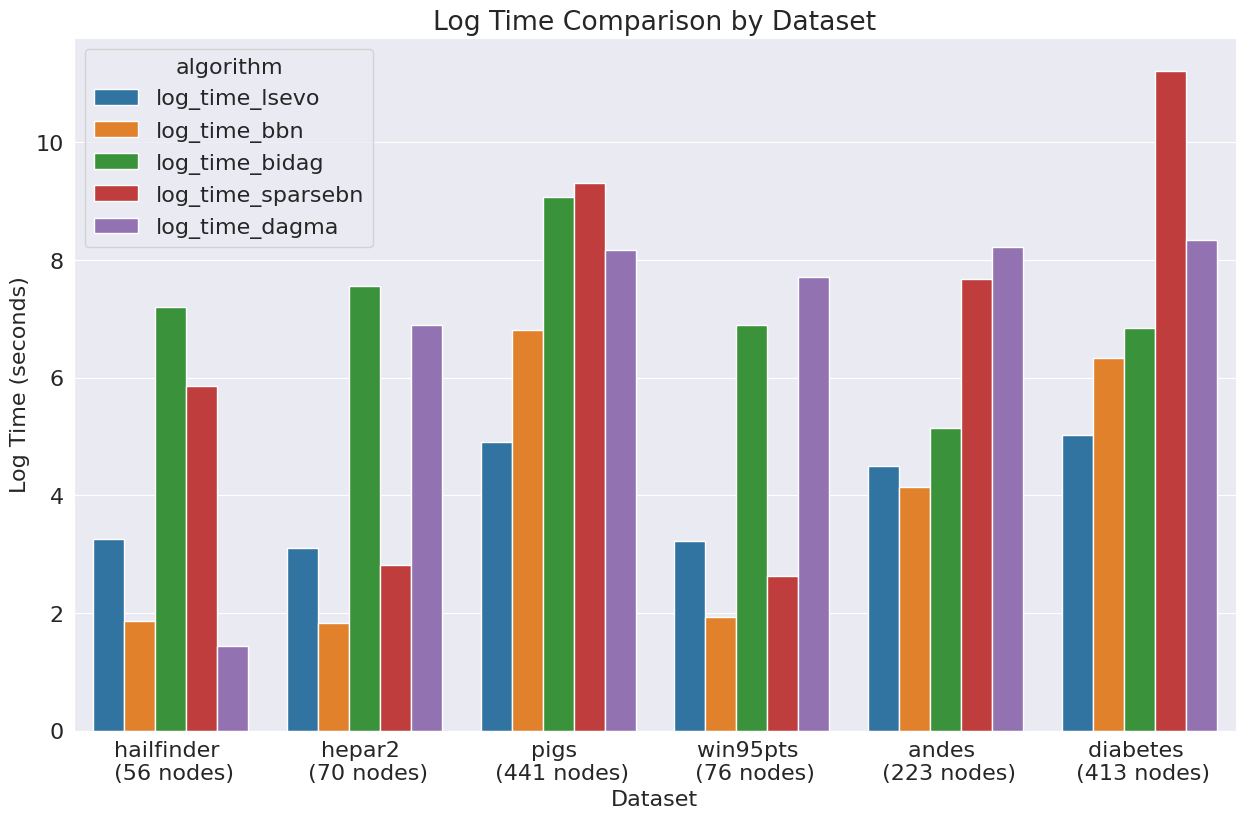

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(data)

df = df[~df['dataset'].isin(['ecoli70', 'magic_niab', 'magic_irri'])]

# Grouped barplot of Log Time by Dataset
plt.figure(figsize=(15, 9))

# Calculate the logarithm of time for each algorithm
df['log_time_lsevo'] = np.log(df['time_lsevo'])
df['log_time_bidag'] = np.log(df['time_bidag'])
df['log_time_sparsebn'] = np.log(df['time_sparsebn'])
df['log_time_bbn'] = np.log(df['time_bbn'])
df['log_time_dagma'] = np.log(df['time_dagma'])

# Create the barplot
sns.barplot(
    x='dataset',
    y='value',
    hue='algorithm',
    data=df.melt(
        id_vars=['dataset', 'data_type'],
        value_vars=['log_time_lsevo', 'log_time_bbn', 'log_time_bidag', 'log_time_sparsebn', 'log_time_dagma'],
        var_name='algorithm',
        value_name='value'
    )
)

# Set labels and title
plt.title('Log Time Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Log Time (seconds)')
plt.show()


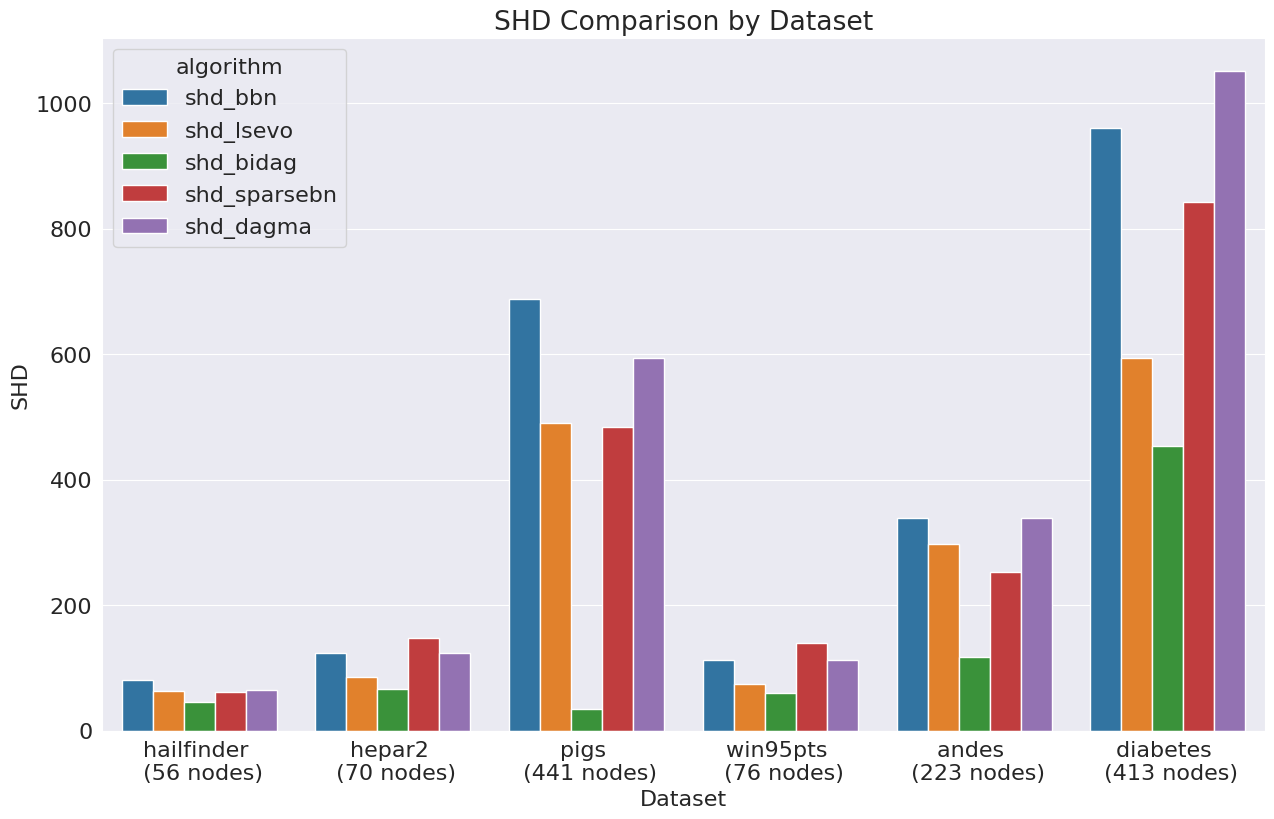

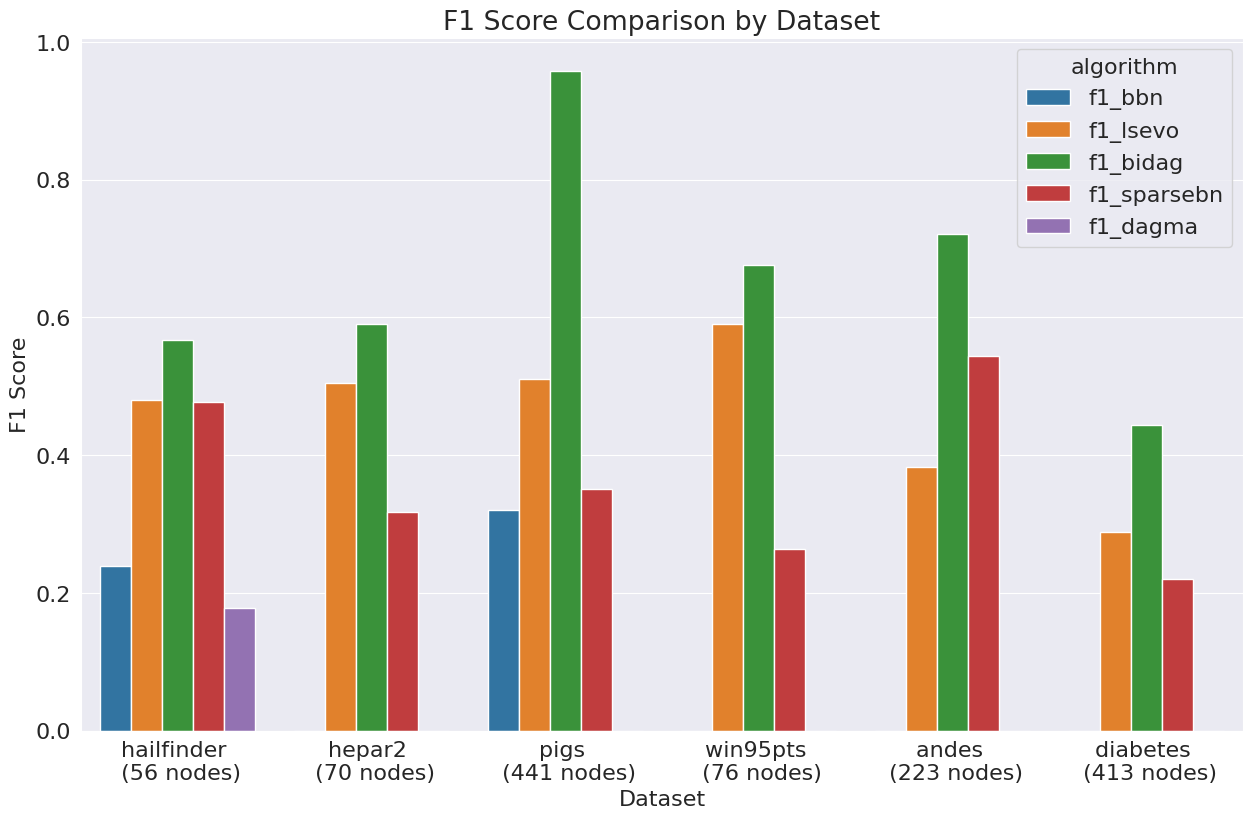

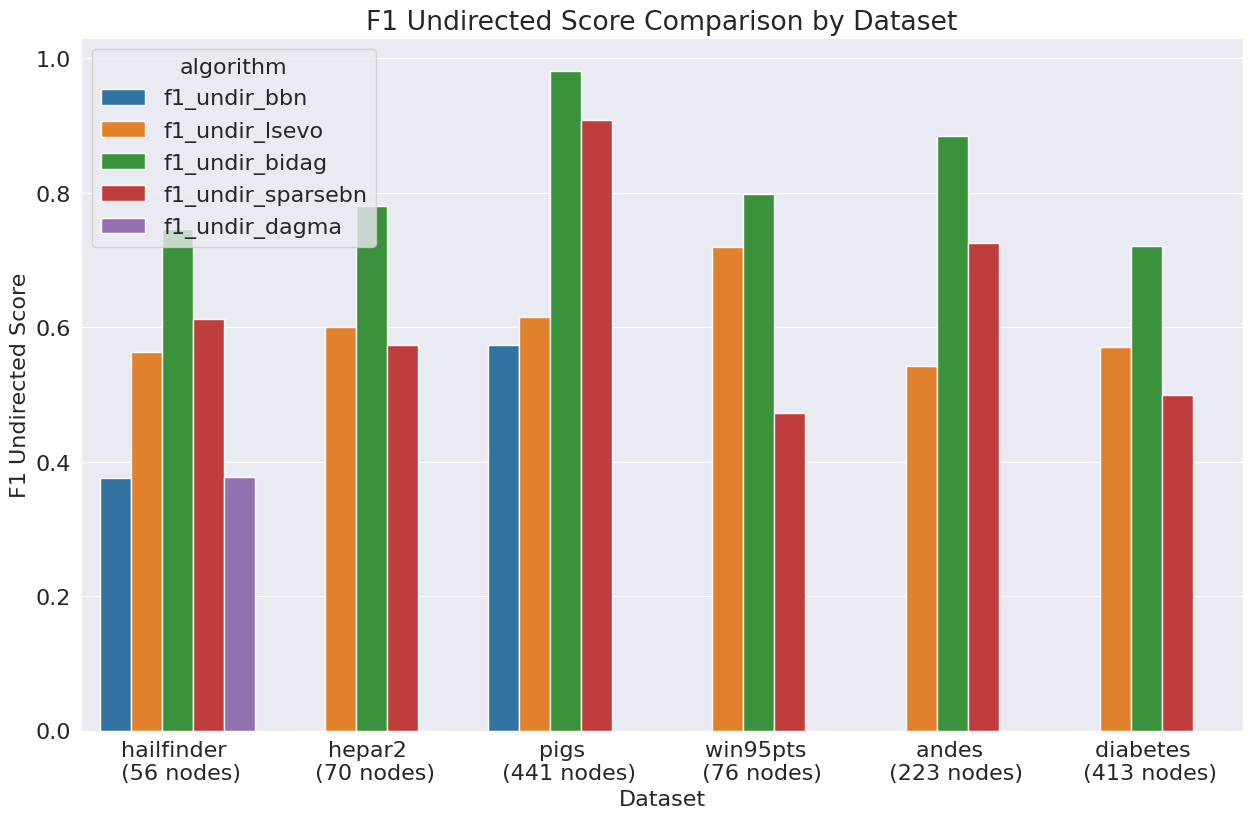

In [6]:
# Grouped barplot of SHD by Dataset
plt.figure(figsize=(15, 9))
sns.barplot(x='dataset', y='shd', hue='algorithm', data=df.melt(id_vars=['dataset', 'data_type'], value_vars=['shd_bbn', 'shd_lsevo', 'shd_bidag', 'shd_sparsebn', 'shd_dagma'], var_name='algorithm', value_name='shd'))
plt.title('SHD Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('SHD')
plt.show()

# Grouped barplot of F1 Score by Dataset
plt.figure(figsize=(15, 9))
sns.barplot(x='dataset', y='f1', hue='algorithm', data=df.melt(id_vars=['dataset', 'data_type'], value_vars=['f1_bbn', 'f1_lsevo', 'f1_bidag', 'f1_sparsebn', 'f1_dagma'], var_name='algorithm', value_name='f1'))
plt.title('F1 Score Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.show()

plt.figure(figsize=(15, 9))
sns.barplot(x='dataset', y='f1_undirected', hue='algorithm', data=df.melt(id_vars=['dataset', 'data_type'], value_vars=['f1_undir_bbn', 'f1_undir_lsevo', 'f1_undir_bidag', 'f1_undir_sparsebn', 'f1_undir_dagma'], var_name='algorithm', value_name='f1_undirected'))
plt.title('F1 Undirected Score Comparison by Dataset')
plt.xlabel('Dataset')
plt.ylabel('F1 Undirected Score')
plt.show()

## Score-function convergence

In [ ]:
import matplotlib.pyplot as plt

# Fitness data
fitness = {'run_1': [51775.062, 46950.692, 46950.692, 43898.075, 43898.075, 43353.780, 43353.780, 43353.780, 43353.780, 43353.780, 43353.780, 43160.255, 43160.255, 43160.255, 43160.255, 43160.255],
'run_2': [52388.294, 46896.789, 45909.773, 43365.164, 42920.946, 42677.318, 42552.277, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150, 42551.150],
'run_3': [49253.299, 46508.138, 45203.675, 45119.051, 43483.064, 42150.214, 42150.214, 42064.240, 41949.812, 41802.151, 41802.151, 41750.152, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527, 41550.527],
'run_4': [49325.263, 46488.362, 45729.883, 45500.434, 43101.351, 42511.529, 42462.224, 42227.904, 42159.111, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738, 42145.738], 
'run_5': [49115.110, 45379.152, 44387.612, 42441.959, 41787.585, 41726.348, 41369.006, 41172.714, 40860.771, 40860.771, 40848.762, 40848.762, 40848.762, 40848.762, 40818.368, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969, 40669.969]}

# Plotting the graph
for key in fitness.keys():
    plt.plot(fitness[key], label=key)
plt.title('LSevoBN: Fitness vs Generations (win95pts dataset)')
plt.xlabel('Generations')
plt.ylabel('Fitness (K2 Score)')
plt.legend()
plt.show()

## Different number of clusters in K-means

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def different_kmeans_test(datasets, num_runs=5):
    results_df = pd.DataFrame(columns=['dataset', 'data_type', 'hidden_nodes_clusters', 'shd', 'f1', 'time'])

    for dataset_name, (data, reference_dag_edges, datatype, max_local_structures) in datasets.items():
        for hidden_nodes_clusters in range(4, 17):
            for i in range(num_runs):
                start_time = time.time()

                custom_dag_edges = get_edges_by_localstructures(data,
                                                                datatype,
                                                                max_local_structures,
                                                                hidden_nodes_clusters,
                                                                time_m=5)

                end_time = time.time()

                structure_learning_time = end_time - start_time

                f1 = f1_score(custom_dag_edges, reference_dag_edges.values.tolist())

                results_df = results_df.append({
                    'dataset': dataset_name,
                    'data_type': datatype,
                    'hidden_nodes_clusters': hidden_nodes_clusters,
                    'shd': float(precision_recall(custom_dag_edges, reference_dag_edges.values.tolist())['SHD']),
                    'f1': f1,
                    'time': structure_learning_time
                }, ignore_index=True)

                print(results_df)

    return results_df


In [ ]:
datasets = {
    "ecoli70": (ecoli70, ecoli70_true, "continuous", 4),
    "magic_irri": (magic_irri, magic_irri_true, "continuous", 4),
    "magic_niab": (magic_niab, magic_niab_true, "continuous", 4),
#    "pigs": (pigs, pigs_true, "discrete", 16),
    "win95pts": (win95pts, win95pts_true, "discrete", 4),
    "hailfinder": (hailfinder, hailfinder_true, "discrete", 8),
    "hepar2": (hepar2, hepar2_true, "discrete", 4)
#    "arth150": (arth150, arth150_true, "continuous", 8),
}

results_df_kmeans_lsevo = different_kmeans_test(datasets)

# results_df_kmeans_lsevo.to_csv('results_df_kmeans_lsevo.csv', index=False)



In [ ]:
# results_df_kmeans_lsevo = pd.read_csv('results_df_kmeans_lsevo.csv')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results_df_kmeans_lsevo)

sns.set(style='whitegrid')
g = sns.FacetGrid(df, col='dataset', height=6, aspect=1)
g.map(sns.boxplot, 'hidden_nodes_clusters', 'f1', order=None)
g.set_axis_labels('Number of Clusters', 'F1 Score')
g.set_titles('{col_name}')

plt.show()

In [ ]:
# Group by dataset, data_type, and hidden_nodes_clusters
grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='win95pts'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False)

# Extract the necessary data
time_data = [group['time'].values for name, group in grouped_results_df]
f1_data = [group['f1'].values for name, group in grouped_results_df]

# Create the boxplots
fig, ax = plt.subplots()
ax.boxplot(time_data, positions=grouped_results_df['hidden_nodes_clusters'].unique(), widths=0.6)
ax.boxplot(f1_data, positions=grouped_results_df['hidden_nodes_clusters'].unique() + 0.4, widths=0.6)

# Add labels and legends
ax.set_xlabel('Number of Hidden Nodes Clusters')
ax.set_ylabel('Time (s) and F1')
ax.legend(['Time', 'F1'])

plt.show()


In [ ]:
results_df_kmeans_lsevo.groupby(['dataset', 'data_type', 'hidden_nodes_clusters']).mean()


In [ ]:
# Group by dataset, data_type, and hidden_nodes_clusters and calculate the mean of each group
grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='win95pts'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False).mean()

# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of Hidden Nodes Clusters')
ax1.set_ylabel('Time (s)', color='tab:red')
ax1.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['time'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('F1', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['f1'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('win95pts (discrete)')
plt.show()

In [ ]:
# Group by dataset, data_type, and hidden_nodes_clusters and calculate the mean of each group
grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='ecoli70'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False).mean()

# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of Hidden Nodes Clusters')
ax1.set_ylabel('Time (s)', color='tab:red')
ax1.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['time'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('F1', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['f1'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('ecoli70 (continuous)')
plt.show()

In [ ]:
# Group by dataset, data_type, and hidden_nodes_clusters and calculate the mean of each group
grouped_results_df = results_df_kmeans_lsevo[results_df_kmeans_lsevo['dataset']=='ecoli70'].groupby(['dataset', 'data_type', 'hidden_nodes_clusters'], as_index=False).mean()

# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of Hidden Nodes Clusters')
ax1.set_ylabel('Time (s)', color='tab:red')
ax1.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['time'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('F1', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(grouped_results_df['hidden_nodes_clusters'], grouped_results_df['f1'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
import itertools

def generate_random_dag(nodes, num_edges):
    all_edges = list(itertools.permutations(nodes, 2))
    random_edges = np.random.choice(len(all_edges), num_edges, replace=False)
    random_dag_edges = [all_edges[i] for i in random_edges]
    return pd.DataFrame(random_dag_edges, columns=["source", "target"])

def calculate_f1_shd_random(networks):
    
    results_df = pd.DataFrame(columns=['dataset',
                                       'shd_random',
                                       'f1_random',
                                       'f1_undir_random'])
    
    for dataset_name, (reference_dag_edges) in networks.items():
        
        nodes = np.unique(reference_dag_edges).tolist()  # Updated to convert to a list
        num_edges = len(reference_dag_edges)
        
        random_dag = generate_random_dag(nodes, num_edges)  # Updated to pass a list of nodes
        
        f1_random = f1_score(random_dag.values.tolist(), reference_dag_edges.values.tolist())   
        f1_undir_random = precision_recall(random_dag.values.tolist(), reference_dag_edges.values.tolist())['F1_undir']      
        shd_random = precision_recall(random_dag.values.tolist(), reference_dag_edges.values.tolist())['SHD']
        
        results_df = results_df.append({
            'dataset': f"{dataset_name}",
            'shd_random': shd_random,
            'f1_random': f1_random,
            'f1_undir_random': f1_undir_random
        }, ignore_index=True)
    
    return results_df


In [ ]:
datasets = {
    "ecoli70": (ecoli70_true),
    "magic_irri": (magic_irri_true),
    "magic_niab": (magic_niab_true),
    "pigs": (pigs_true),
    "win95pts": (win95pts_true),
    "hailfinder": (hailfinder_true),
    "hepar2": (hepar2_true),
    "andes": (andes_true),
    "diabetes": (diabetes_true)
#    "arth150": (arth150, arth150_true, "continuous", 8),
}

random_generated_res = calculate_f1_shd_random(datasets)

print(random_generated_res)

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

data_lsevo = {'dataset': ['ecoli70', 'hailfinder', 'hepar2', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'andes', 'diabetes'],
              'shd_lsevo': [39.66, 63.33, 85.0, 77.333333, 54.666667, 490.0, 74.0, 297.33, 594.0],
              'f1_lsevo': [0.572215, 0.479836, 0.505263, 0.328704, 0.282016, 0.510259, 0.589862, 0.382214, 0.287690],
              'f1_undir_lsevo': [0.7732, 0.563233, 0.600000, 0.576600, 0.718400, 0.615500, 0.718900, 0.542433, 0.570167]}

# Random DAGs data
data_random = {'dataset': ['ecoli70', 'magic_irri', 'magic_niab', 'pigs', 'win95pts', 'hailfinder', 'hepar2', 'andes', 'diabetes'],
               'shd_random': [134, 200, 125, 1179, 211, 129, 238, 669, 1200],
               'f1_random': [0.028571, 0.009804, 0.015152, 0.003378, 0.035714, 0.015152, 0.032520, 0.005917, 0.001661],
               'f1_undir_random': [0.0571, 0.0294, 0.0909, 0.0051, 0.0804, 0.0303, 0.0325, 0.0148, 0.0050]}

# Combine the data into a single DataFrame
df_lsevo = pd.DataFrame(data_lsevo)
df_random = pd.DataFrame(data_random)
df_combined = pd.merge(df_lsevo, df_random, on='dataset')

df_combined = df_combined[~df_combined['dataset'].isin(['ecoli70', 'magic_niab', 'magic_irri'])]

# Plot the comparison
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

fig.suptitle('Comparison of SHD and F1 scores between LSevoBN and Random DAGs')

# SHD comparison
sns.barplot(x='dataset', y='value', hue='type', data=df_combined.melt(id_vars='dataset', value_vars=['shd_lsevo', 'shd_random'], var_name='type', value_name='value'), ax=axs[0])
axs[0].set_title('SHD Comparison')
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('SHD')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

sns.barplot(x='dataset', y='value', hue='type', data=df_combined.melt(id_vars='dataset', value_vars=['f1_lsevo', 'f1_random'], var_name='type', value_name='value'), ax=axs[1])
axs[1].set_title('F1 Comparison')
axs[1].set_xlabel('Dataset')
axs[1].set_ylabel('F1')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

sns.barplot(x='dataset', y='value', hue='type', data=df_combined.melt(id_vars='dataset', value_vars=['f1_undir_lsevo', 'f1_undir_random'], var_name='type', value_name='value'), ax=axs[2])
axs[2].set_title('F1 Undirected Comparison')
axs[2].set_xlabel('Dataset')
axs[2].set_ylabel('F1 Undirected')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)

In [ ]:
# import pandas as pd
# import numpy as np
# from pgmpy.estimators import HillClimbSearch, K2Score
# from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
# from sklearn.metrics import mutual_info_score
# import math
# import logging
# import time
# 
# # Setup logger
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger()
# 
# # Load datasets
# datasets = {
#     "pigs": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs.csv'),
#     "win95pts": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts.csv'),
#     "hailfinder": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder.csv'),
#     "hepar2": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2.csv'),
#     "arth150": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150.csv'),
#     "ecoli70": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70.csv', index_col=0),
#     "magic_irri": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri.csv', index_col=0),
#     "magic_niab": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab.csv', index_col=0),
#     "diabetes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/diabetes.csv'),
#     "andes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/andes.csv')
# }
# 
# # Load true structures with headers V1 and V2 for the first eight datasets, and no headers for the last two
# true_structures = {
#     "pigs": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_true.csv', header=0),
#     "win95pts": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_true.csv', header=0),
#     "hailfinder": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_true.csv', header=0),
#     "hepar2": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_true.csv', header=0),
#     "arth150": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_true.csv', header=0),
#     "ecoli70": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_true.csv', header=0),
#     "magic_irri": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_true.csv', header=0),
#     "magic_niab": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_true.csv', header=0),
#     "diabetes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/truenetworks/diabetes_true.txt', header=None, names=['V1', 'V2']),
#     "andes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/truenetworks/andes_true.txt', header=None, names=['V1', 'V2'])
# }
# 
# # BigBraveBN Class
# class BigBraveBN:
#     def __init__(self):
#         self.possible_edges = []
# 
#     def set_possible_edges_by_brave(
#         self,
#         df: pd.DataFrame,
#         n_nearest: int = 5,
#         threshold: float = 0.3,
#         proximity_metric: str = "MI",
#     ) -> list:
#         df_copy = df.copy(deep=True)
#         proximity_matrix = self._get_proximity_matrix(df_copy, proximity_metric)
#         brave_matrix = self._get_brave_matrix(df_copy.columns, proximity_matrix, n_nearest)
# 
#         threshold_value = brave_matrix.max(numeric_only=True).max() * threshold
#         filtered_brave_matrix = brave_matrix[brave_matrix > threshold_value].stack()
#         self.possible_edges = filtered_brave_matrix.index.tolist()
#         return self.possible_edges
# 
#     @staticmethod
#     def _get_n_nearest(data: pd.DataFrame, columns: list, corr: bool = False, number_close: int = 5) -> list:
#         groups = []
#         for c in columns:
#             close_ind = data[c].sort_values(ascending=not corr).index.tolist()
#             groups.append(close_ind[: number_close + 1])
#         return groups
# 
#     @staticmethod
#     def _get_proximity_matrix(df: pd.DataFrame, proximity_metric: str) -> pd.DataFrame:
#         encoder = OrdinalEncoder()
#         df_coded = df.copy()
#         columns_to_encode = list(df_coded.select_dtypes(include=["category", "object"]))
#         df_coded[columns_to_encode] = encoder.fit_transform(df_coded[columns_to_encode])
# 
#         if proximity_metric == "MI":
#             df_distance = pd.DataFrame(
#                 np.zeros((len(df.columns), len(df.columns))),
#                 columns=df.columns,
#                 index=df.columns,
#             )
#             for c1 in df.columns:
#                 for c2 in df.columns:
#                     dist = mutual_info_score(df_coded[c1].values, df_coded[c2].values)
#                     df_distance.loc[c1, c2] = dist
#             return df_distance
# 
#         elif proximity_metric == "pearson":
#             return df_coded.corr(method="pearson")
# 
#     def _get_brave_matrix(self, df_columns: pd.Index, proximity_matrix: pd.DataFrame, n_nearest: int = 5) -> pd.DataFrame:
#         brave_matrix = pd.DataFrame(
#             np.zeros((len(df_columns), len(df_columns))),
#             columns=df_columns,
#             index=df_columns,
#         )
#         groups = self._get_n_nearest(proximity_matrix, df_columns.tolist(), corr=True, number_close=n_nearest)
# 
#         for c1 in df_columns:
#             for c2 in df_columns:
#                 a = b = c = d = 0.0
#                 if c1 != c2:
#                     for g in groups:
#                         a += (c1 in g) & (c2 in g)
#                         b += (c1 in g) & (c2 not in g)
#                         c += (c1 not in g) & (c2 in g)
#                         d += (c1 not in g) & (c2 not in g)
# 
#                     divisor = (math.sqrt((a + c) * (b + d))) * (math.sqrt((a + b) * (c + d)))
#                     br = (a * len(groups) + (a + c) * (a + b)) / (divisor if divisor != 0 else 0.0000000001)
#                     brave_matrix.loc[c1, c2] = br
# 
#         return brave_matrix
# 
#     def preprocess_data(self, data_cluster):
#         encoder = LabelEncoder()
#         discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
#         for col in data_cluster.columns:
#             if data_cluster[col].dtype == 'object':
#                 data_cluster[col] = encoder.fit_transform(data_cluster[col])
#         discretized_data = pd.DataFrame(discretizer.fit_transform(data_cluster), columns=data_cluster.columns)
#         info = {col: 'discrete' for col in data_cluster.columns}
#         return discretized_data, info
# 
# # Evaluation Functions
# def f1_score(custom_dag_edges, reference_dag_edges):
#     tp = fp = fn = 0
#     for edge in custom_dag_edges:
#         if edge in reference_dag_edges:
#             tp += 1
#         else:
#             fp += 1
# 
#     for edge in reference_dag_edges:
#         if edge not in custom_dag_edges:
#             fn += 1
# 
#     if tp + fp == 0:
#         precision = 0
#     else:
#         precision = tp / (tp + fp)
# 
#     if tp + fn == 0:
#         recall = 0
#     else:
#         recall = tp / (tp + fn)
# 
#     if precision + recall == 0:
#         f1 = 0
#     else:
#         f1 = 2 * precision * recall / (precision + recall)
# 
#     return f1
# 
# def child_dict(net: list):
#     res_dict = dict()
#     for e0, e1 in net:
#         if e1 in res_dict:
#             res_dict[e1].append(e0)
#         else:
#             res_dict[e1] = [e0]
#     return res_dict
# 
# def precision_recall(pred_net: list, true_net: list, decimal = 4):
#     pred_dict = child_dict(pred_net)
#     true_dict = child_dict(true_net)
#     corr_undir = 0
#     corr_dir = 0
#     for e0, e1 in pred_net:
#         flag = True
#         if e1 in true_dict:
#             if e0 in true_dict[e1]:
#                 corr_undir += 1
#                 corr_dir += 1
#                 flag = False
#         if (e0 in true_dict) and flag:
#             if e1 in true_dict[e0]:
#                 corr_undir += 1
#     pred_len = len(pred_net)
#     true_len = len(true_net)
#     shd = pred_len + true_len - corr_undir - corr_dir
#     return {'SHD': shd}
# 
# def f1_score_undirected(custom_dag_edges, reference_dag_edges):
#     custom_dag_edges_set = {frozenset((str(a), str(b))) for a, b in custom_dag_edges}
#     reference_dag_edges_set = {frozenset((str(a), str(b))) for a, b in reference_dag_edges}
# 
#     tp = fp = fn = 0
#     for edge in custom_dag_edges_set:
#         if edge in reference_dag_edges_set:
#             tp += 1
#         else:
#             fp += 1
# 
#     for edge in reference_dag_edges_set:
#         if edge not in custom_dag_edges_set:
#             fn += 1
# 
#     if tp + fp == 0:
#         precision = 0
#     else:
#         precision = tp / (tp + fp)
# 
#     if tp + fn == 0:
#         recall = 0
#     else:
#         recall = tp / (tp + fn)
# 
#     if precision + recall == 0:
#         f1 = 0
#     else:
#         f1 = 2 * precision * recall / (precision + recall)
# 
#     return f1
# 
# # Main Evaluation Loop
# def evaluate_bn_structure_learning(datasets, true_structures):
#     results = {
#         "dataset": [],
#         "data_type": [],
#         "shd_lsevo": [],
#         "f1_lsevo": [],
#         "time_lsevo": [],
#         "f1_undir_lsevo": [],
#     }
# 
#     thresholds = {
#         "pigs": 0.5,
#         "win95pts": 0.3,
#         "hailfinder": 0.3,
#         "hepar2": 0.3,
#         "arth150": 0.3,
#         "ecoli70": 0.3,
#         "magic_irri": 0.3,
#         "magic_niab": 0.3,
#         "diabetes": 0.6,
#         "andes": 0.5
#     }
# 
#     data_types = {
#         "pigs": "discrete",
#         "win95pts": "discrete",
#         "hailfinder": "discrete",
#         "hepar2": "discrete",
#         "arth150": "discrete",
#         "ecoli70": "continuous",
#         "magic_irri": "continuous",
#         "magic_niab": "continuous",
#         "diabetes": "discrete",
#         "andes": "discrete"
#     }
# 
#     for name, data in datasets.items():
#         logger.info(f"Starting evaluation for dataset: {name}")
#         
#         true_structure = true_structures[name]
#         true_edges = list(zip(true_structure['V1'], true_structure['V2']))
# 
#         brave_bn = BigBraveBN()
#         metrics = {"F1": [], "F1_undirected": [], "SHD": [], "Time": []}
# 
#         for i in range(5):
#             logger.info(f"Run {i+1} for dataset: {name}")
#             start_time = time.time()
#             
#             preprocessed_data, _ = brave_bn.preprocess_data(data)
#             possible_edges = brave_bn.set_possible_edges_by_brave(preprocessed_data, threshold=thresholds[name])
#             hc = HillClimbSearch(preprocessed_data)
#             model = hc.estimate(scoring_method=K2Score(preprocessed_data), white_list=possible_edges)
# 
#             end_time = time.time()
#             elapsed_time = end_time - start_time
# 
#             predicted_edges = model.edges()
# 
#             metrics["F1"].append(f1_score(predicted_edges, true_edges))
#             metrics["F1_undirected"].append(f1_score_undirected(predicted_edges, true_edges))
#             metrics["SHD"].append(precision_recall(predicted_edges, true_edges)['SHD'])
#             metrics["Time"].append(elapsed_time)
# 
#         results["dataset"].append(name)
#         results["data_type"].append(data_types[name])
#         results["shd_lsevo"].append(np.mean(metrics["SHD"]))
#         results["f1_lsevo"].append(np.mean(metrics["F1"]))
#         results["time_lsevo"].append(np.mean(metrics["Time"]))
#         results["f1_undir_lsevo"].append(np.mean(metrics["F1_undirected"]))
#         
#         logger.info(f"Completed evaluation for dataset: {name} with Average Time: {results['time_lsevo'][-1]:.2f} seconds")
# 
#     return results
# 
# # Run the evaluation
# results = evaluate_bn_structure_learning(datasets, true_structures)
# results_df = pd.DataFrame(results)
# print(results_df)


In [ ]:
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid


def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est

from scipy.special import expit as sigmoid
import igraph as ig
import random


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()


def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


def simulate_linear_sem(W, n, sem_type, noise_scale=None):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = np.random.normal(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')
    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
    return X


def simulate_nonlinear_sem(B, n, sem_type, noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X


def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}


In [3]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, K2Score
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.metrics import mutual_info_score
import math
import logging
import time
import torch
from dagma import utils as dagma_utils
from dagma.linear import DagmaLinear

# Setup logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Load datasets
datasets = {
    # "pigs": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs.csv'),
    # "win95pts": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts.csv'),
    # "hailfinder": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder.csv'),
    # "hepar2": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2.csv'),
    # "arth150": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150.csv'),
    # "ecoli70": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70.csv', index_col=0),
    # "magic_irri": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri.csv', index_col=0),
    # "magic_niab": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab.csv', index_col=0),
    # "diabetes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/diabetes.csv'),
    "andes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/data/andes.csv')
}

# Load true structures with headers V1 and V2 for the first eight datasets, and no headers for the last two
true_structures = {
    # "pigs": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_true.csv', header=0),
    # "win95pts": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_true.csv', header=0),
    # "hailfinder": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_true.csv', header=0),
    # "hepar2": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_true.csv', header=0),
    # "arth150": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_true.csv', header=0),
    # "ecoli70": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_true.csv', header=0),
    # "magic_irri": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_true.csv', header=0),
    # "magic_niab": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_true.csv', header=0),
    # "diabetes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/truenetworks/diabetes_true.txt', header=None, names=['V1', 'V2']),
    "andes": pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/sparsebndata/main/truenetworks/andes_true.txt', header=None, names=['V1', 'V2'])
}

# BigBraveBN Class
class BigBraveBN:
    def __init__(self):
        self.possible_edges = []

    def set_possible_edges_by_brave(
        self,
        df: pd.DataFrame,
        n_nearest: int = 5,
        threshold: float = 0.3,
        proximity_metric: str = "MI",
    ) -> list:
        df_copy = df.copy(deep=True)
        proximity_matrix = self._get_proximity_matrix(df_copy, proximity_metric)
        brave_matrix = self._get_brave_matrix(df_copy.columns, proximity_matrix, n_nearest)

        threshold_value = brave_matrix.max(numeric_only=True).max() * threshold
        filtered_brave_matrix = brave_matrix[brave_matrix > threshold_value].stack()
        self.possible_edges = filtered_brave_matrix.index.tolist()
        return self.possible_edges

    @staticmethod
    def _get_n_nearest(data: pd.DataFrame, columns: list, corr: bool = False, number_close: int = 5) -> list:
        groups = []
        for c in columns:
            close_ind = data[c].sort_values(ascending=not corr).index.tolist()
            groups.append(close_ind[: number_close + 1])
        return groups

    @staticmethod
    def _get_proximity_matrix(df: pd.DataFrame, proximity_metric: str) -> pd.DataFrame:
        encoder = OrdinalEncoder()
        df_coded = df.copy()
        columns_to_encode = list(df_coded.select_dtypes(include=["category", "object"]))
        df_coded[columns_to_encode] = encoder.fit_transform(df_coded[columns_to_encode])

        if proximity_metric == "MI":
            df_distance = pd.DataFrame(
                np.zeros((len(df.columns), len(df.columns))),
                columns=df.columns,
                index=df.columns,
            )
            for c1 in df.columns:
                for c2 in df.columns:
                    dist = mutual_info_score(df_coded[c1].values, df_coded[c2].values)
                    df_distance.loc[c1, c2] = dist
            return df_distance

        elif proximity_metric == "pearson":
            return df_coded.corr(method="pearson")

    def _get_brave_matrix(self, df_columns: pd.Index, proximity_matrix: pd.DataFrame, n_nearest: int = 5) -> pd.DataFrame:
        brave_matrix = pd.DataFrame(
            np.zeros((len(df_columns), len(df_columns))),
            columns=df_columns,
            index=df_columns,
        )
        groups = self._get_n_nearest(proximity_matrix, df_columns.tolist(), corr=True, number_close=n_nearest)

        for c1 in df_columns:
            for c2 in df_columns:
                a = b = c = d = 0.0
                if c1 != c2:
                    for g in groups:
                        a += (c1 in g) & (c2 in g)
                        b += (c1 in g) & (c2 not in g)
                        c += (c1 not in g) & (c2 in g)
                        d += (c1 not in g) & (c2 not in g)

                    divisor = (math.sqrt((a + c) * (b + d))) * (math.sqrt((a + b) * (c + d)))
                    br = (a * len(groups) + (a + c) * (a + b)) / (divisor if divisor != 0 else 0.0000000001)
                    brave_matrix.loc[c1, c2] = br

        return brave_matrix

    def preprocess_data(self, data_cluster):
        encoder = LabelEncoder()
        discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        for col in data_cluster.columns:
            if data_cluster[col].dtype == 'object':
                data_cluster[col] = encoder.fit_transform(data_cluster[col])
        discretized_data = pd.DataFrame(discretizer.fit_transform(data_cluster), columns=data_cluster.columns)
        info = {col: 'discrete' for col in data_cluster.columns}
        return discretized_data, info

# Evaluation Functions
def f1_score(custom_dag_edges, reference_dag_edges):
    tp = fp = fn = 0
    for edge in custom_dag_edges:
        if edge in reference_dag_edges:
            tp += 1
        else:
            fp += 1

    for edge in reference_dag_edges:
        if edge not in custom_dag_edges:
            fn += 1

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return f1

def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal = 4):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'SHD': shd}

def f1_score_undirected(custom_dag_edges, reference_dag_edges):
    custom_dag_edges_set = {frozenset((str(a), str(b))) for a, b in custom_dag_edges}
    reference_dag_edges_set = {frozenset((str(a), str(b))) for a, b in reference_dag_edges}

    tp = fp = fn = 0
    for edge in custom_dag_edges_set:
        if edge in reference_dag_edges_set:
            tp += 1
        else:
            fp += 1

    for edge in reference_dag_edges_set:
        if edge not in custom_dag_edges_set:
            fn += 1

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return f1

def reassign_edges(edges, columns):
    return [(columns[i], columns[j]) for i, j in edges]

def evaluate_bn_structure_learning(datasets, true_structures):
    results = {
        "dataset": [],
        "data_type": [],
        "shd_bbn": [],
        "f1_bbn": [],
        "time_bbn": [],
        "f1_undir_bbn": [],
        # "shd_dagma": [],
        # "f1_dagma": [],
        # "time_dagma": [],
        # "f1_undir_dagma": []
    }

    thresholds = {
        # "pigs": 0.5,
        # "win95pts": 0.1,
        # "hailfinder": 0.3,
        # "hepar2": 0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001,
        # "arth150": 0.3,
        # "ecoli70": 0.3,
        # "magic_irri": 0.3,
        # "magic_niab": 0.3,
        # "diabetes": 0.6,
        "andes": 0.00000000000000001
    }

    data_types = {
        # "pigs": "discrete",
        # "win95pts": "discrete",
        # "hailfinder": "discrete",
        # "hepar2": "discrete",
        # "arth150": "discrete",
        # "ecoli70": "continuous",
        # "magic_irri": "continuous",
        # "magic_niab": "continuous",
        # "diabetes": "discrete",
        "andes": "discrete"
    }

    for name, data in datasets.items():
        logger.info(f"Starting evaluation for dataset: {name}")
        
        true_structure = true_structures[name]
        true_edges = list(zip(true_structure['V1'], true_structure['V2']))

        brave_bn = BigBraveBN()
        metrics_lsevo = {"F1": [], "F1_undirected": [], "SHD": [], "Time": []}
        # metrics_dagma = {"F1": [], "F1_undirected": [], "SHD": [], "Time": []}

        for i in range(1):
            logger.info(f"Run {i+1} for dataset: {name}")

            # BigBraveBN + LSEvo
            start_time = time.time()
            
            preprocessed_data, _ = brave_bn.preprocess_data(data)
            possible_edges = brave_bn.set_possible_edges_by_brave(preprocessed_data, threshold=thresholds[name])
            hc = HillClimbSearch(preprocessed_data)
            model = hc.estimate(scoring_method=K2Score(preprocessed_data), white_list=possible_edges)

            end_time = time.time()
            elapsed_time = end_time - start_time

            predicted_edges = model.edges()

            metrics_lsevo["F1"].append(f1_score(predicted_edges, true_edges))
            metrics_lsevo["F1_undirected"].append(f1_score_undirected(predicted_edges, true_edges))
            metrics_lsevo["SHD"].append(precision_recall(predicted_edges, true_edges)['SHD'])
            metrics_lsevo["Time"].append(elapsed_time)

            # # DAGMA
            # start_time = time.time()
            # X = preprocessed_data.values
            # model = DagmaLinear(loss_type='l2')
            # W_est = model.fit(X, lambda1=0.02)
            # end_time = time.time()
            # elapsed_time = end_time - start_time
            # 
            # predicted_edges_dagma = [(i, j) for i in range(W_est.shape[0]) for j in range(W_est.shape[1]) if W_est[i, j] != 0]
            # predicted_edges_dagma = reassign_edges(predicted_edges_dagma, data.columns)
            # print(predicted_edges_dagma)
            # metrics_dagma["F1"].append(f1_score(predicted_edges_dagma, true_edges))
            # metrics_dagma["F1_undirected"].append(f1_score_undirected(predicted_edges_dagma, true_edges))
            # metrics_dagma["SHD"].append(precision_recall(predicted_edges_dagma, true_edges)['SHD'])
            # metrics_dagma["Time"].append(elapsed_time)

        results["dataset"].append(name)
        results["data_type"].append(data_types[name])
        results["shd_bbn"].append(np.mean(metrics_lsevo["SHD"]))
        results["f1_bbn"].append(np.mean(metrics_lsevo["F1"]))
        results["time_bbn"].append(np.mean(metrics_lsevo["Time"]))
        results["f1_undir_bbn"].append(np.mean(metrics_lsevo["F1_undirected"]))
        # results["shd_dagma"].append(np.mean(metrics_dagma["SHD"]))
        # results["f1_dagma"].append(np.mean(metrics_dagma["F1"]))
        # results["time_dagma"].append(np.mean(metrics_dagma["Time"]))
        # results["f1_undir_dagma"].append(np.mean(metrics_dagma["F1_undirected"]))
        
        logger.info(f"Completed evaluation for dataset: {name} with Average Time LSEvo: {results['time_bbn'][-1]:.2f}")

    return results

# Run the evaluation
results = evaluate_bn_structure_learning(datasets, true_structures)
results_df = pd.DataFrame(results)
print(results_df)


2024-06-19 16:44:34,811 - INFO - Starting evaluation for dataset: andes
2024-06-19 16:44:34,811 - INFO - Run 1 for dataset: andes
/home/jerzy/Documents/GitHub/GOLEM/venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jerzy/Documents/GitHub/GOLEM/venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jerzy/Documents/GitHub/GOLEM/venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jerzy/Documents/GitHub/GOLEM/venv/lib/python3.10/site-packages/sklearn/preprocessing/_disc

  0%|          | 0/1000000 [00:00<?, ?it/s]

2024-06-19 16:45:38,885 - INFO - Completed evaluation for dataset: andes with Average Time LSEvo: 64.07


  dataset data_type  shd_bbn  f1_bbn   time_bbn  f1_undir_bbn
0   andes  discrete    338.0     0.0  64.071359           0.0


In [5]:
results_df

,dataset,data_type,shd_lsevo,f1_lsevo,time_lsevo,f1_undir_lsevo,shd_dagma,f1_dagma,time_dagma,f1_undir_dagma
0,pigs,discrete,688.0,0.319936,899.076205,0.573955,593.0,0.000000,3549.347085,0.000000
1,win95pts,discrete,112.0,0.000000,6.888312,0.000000,112.0,0.000000,2212.399516,0.000000
2,hailfinder,discrete,81.0,0.239316,6.436981,0.376068,65.0,0.177778,4.187404,0.377778
3,hepar2,discrete,123.0,0.000000,6.271100,0.000000,123.0,0.000000,989.088115,0.000000
4,arth150,discrete,247.0,0.000000,27.879689,0.688259,217.0,0.000000,2028.950544,0.617512
5,ecoli70,continuous,46.0,0.535433,5.929461,0.740157,51.0,0.462810,3.923299,0.694215
6,magic_irri,continuous,79.0,0.305732,10.764610,0.687898,96.0,0.096000,3.999641,0.368000
7,magic_niab,continuous,51.0,0.288462,5.364017,0.730769,64.0,0.057143,1.870904,0.114286
8,diabetes,discrete,961.0,0.000000,558.342260,0.000000,1052.0,0.000000,4177.805352,0.000000
9,andes,discrete,338.0,0.000000,63.081139,0.000000,338.0,0.000000,3685.070266,0.000000


In [6]:
results

{'dataset': ['pigs',
  'win95pts',
  'hailfinder',
  'hepar2',
  'arth150',
  'ecoli70',
  'magic_irri',
  'magic_niab',
  'diabetes',
  'andes'],
 'data_type': ['discrete',
  'discrete',
  'discrete',
  'discrete',
  'discrete',
  'continuous',
  'continuous',
  'continuous',
  'discrete',
  'discrete'],
 'shd_lsevo': [688.0,
  112.0,
  81.0,
  123.0,
  247.0,
  46.0,
  79.0,
  51.0,
  961.0,
  338.0],
 'f1_lsevo': [0.319935691318328,
  0.0,
  0.2393162393162393,
  0.0,
  0.0,
  0.5354330708661418,
  0.3057324840764331,
  0.28846153846153844,
  0.0,
  0.0],
 'time_lsevo': [899.0762053966522,
  6.8883123874664305,
  6.436980581283569,
  6.2710999011993405,
  27.879689264297486,
  5.929460620880127,
  10.764610052108765,
  5.364017057418823,
  558.3422603130341,
  63.081138610839844],
 'f1_undir_lsevo': [0.5739549839228295,
  0.0,
  0.37606837606837606,
  0.0,
  0.6882591093117408,
  0.7401574803149606,
  0.6878980891719745,
  0.7307692307692308,
  0.0,
  0.0],
 'shd_dagma': [593.0,
  1

In [ ]:
{'dataset': ['pigs',
  'win95pts',
  'hailfinder',
  'hepar2',
  'arth150',
  'ecoli70',
  'magic_irri',
  'magic_niab',
  'diabetes',
  'andes'],
 'data_type': ['discrete',
  'discrete',
  'discrete',
  'discrete',
  'discrete',
  'continuous',
  'continuous',
  'continuous',
  'discrete',
  'discrete'],
 'shd_lsevo': [688.0,
  112.0,
  81.0,
  123.0,
  247.0,
  46.0,
  79.0,
  51.0,
  961.0,
  338.0],
 'f1_lsevo': [0.319935691318328,
  0.0,
  0.2393162393162393,
  0.0,
  0.0,
  0.5354330708661418,
  0.3057324840764331,
  0.28846153846153844,
  0.0,
  0.0],
 'time_lsevo': [899.0762053966522,
  6.8883123874664305,
  6.436980581283569,
  6.2710999011993405,
  27.879689264297486,
  5.929460620880127,
  10.764610052108765,
  5.364017057418823,
  558.3422603130341,
  63.081138610839844],
 'f1_undir_lsevo': [0.5739549839228295,
  0.0,
  0.37606837606837606,
  0.0,
  0.6882591093117408,
  0.7401574803149606,
  0.6878980891719745,
  0.7307692307692308,
  0.0,
  0.0],
 'shd_dagma': [593.0,
  112.0,
  65.0,
  123.0,
  217.0,
  51.0,
  96.0,
  64.0,
  1052.0,
  338.0],
 'f1_dagma': [0.0,
  0.0,
  0.17777777777777776,
  0.0,
  0.0,
  0.46280991735537197,
  0.09599999999999999,
  0.05714285714285715,
  0.0,
  0.0],
 'time_dagma': [3549.34708480835,
  2212.3995155334474,
  4.187403678894043,
  989.0881148815155,
  2028.950544166565,
  3.9232993602752684,
  3.999641466140747,
  1.8709041118621825,
  4177.805352163315,
  3685.0702658176424],
 'f1_undir_dagma': [0.0,
  0.0,
  0.37777777777777777,
  0.0,
  0.6175115207373272,
  0.6942148760330579,
  0.368,
  0.1142857142857143,
  0.0,
  0.0]}